In [4]:
import sys
sys.path.append("..")

In [5]:
# %pip install dash

In [6]:
# %pip install UMAP
# %pip install umap
# %pip install --upgrade umap-learn
# %pip install -U kaleido

In [7]:
# %pip install loguru
# %pip install numpy
# %pip install openai
# %pip install plotly

In [8]:
# %pip install nbformat==4.2.0


In [9]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances, cosine_distances
import numpy as np
import logging
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import plotly.express as px
import matplotlib.colors as mcolors
import warnings
import io
from PIL import Image
import nbformat
import IPython
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from dch_etl.azure_clients.openai_client import OpenAiClient
import plotly.io as pio
from sklearn.metrics import pairwise
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import MinCovDet
from sklearn.neighbors import NearestNeighbors
from collections import Counter

import nbconvert
import networkx as nx
#from azure.core.credentials import AzureKeyCredential
#from azure.search.documents import SearchClient

In [10]:
from dch_etl.processor.labeling_chunks_process import LabelingChunksProcessor

## Importar y crear df

In [11]:
import csv

file_path = 'C:\\Users\\55641856\\Desktop\\prep-script\\cluster_centroids.csv'
with open(file_path, "r") as file:
    reader = csv.DictReader(file)
    keys = reader.fieldnames
    results = list(reader)

In [12]:
centroides_df = pd.read_csv(file_path)

# Check if the specified columns exist before selecting them
columns = ['cluster_label', 'centroid', 'etiqueta']
missing_columns = [col for col in columns if col not in centroides_df.columns]

if missing_columns:
    print(f"Warning: The following columns are missing: {missing_columns}")
else:
    centroides_df = centroides_df[columns]


In [13]:
import json

file_path = 'C:\\Users\\55641856\\Desktop\\prep-script\\documentos_pre.json'
with open(file_path, "r") as file:
    results2 = json.load(file)

In [14]:
results2[0].keys()

dict_keys(['document_path', 'ts_file_update', 'category', 'description', 'original_canonic_path', 'content_vector', 'dt_end', 'document_id', 'file_size', 'calendar_name', 'location', 'site_name', 'sp', 'title', 'sheet_name', 'event_id', 'event_name', 'dt_start', 'content', 'etiqueta_cluster', 'event_url', 'ts_creation', 'original_path', 'content_md', 'document_name', 'chunk_id', 'content_type', 'id', 'ts_processed', 'page_number', '@search.score', '@search.reranker_score', '@search.highlights', '@search.captions'])

In [15]:
embeddings_df = pd.DataFrame(results2)[['original_path', "id", "content", "content_type","category", "content_vector", 'document_id', 'chunk_id', 'page_number', 'event_url', 'document_name', 'title', 'description']]

Normalizar los vectores en content_vector

In [16]:
# Función para normalizar un vector
def normalizar_vector(vector):
    norma = np.linalg.norm(vector)
    return vector / norma if norma != 0 else vector

# Aplicar la normalización a cada vector en la columna content_vector
embeddings_df['content_vector_norm'] = embeddings_df['content_vector'].apply(normalizar_vector)

Asignar etiqueta a cada embedding normalizado

In [17]:
# Convertir centroides a un array de numpy, asegurando que son numéricos
centroides = np.array([np.fromstring(c[1:-1], sep=',') for c in centroides_df['centroid'].values])

# # Verifica las dimensiones
# print("Dimensiones de los embeddings:", embeddings_df['content_vector_norm'].iloc[0].shape)
# print("Dimensiones de los centroides:", centroides.shape)

# Función para calcular la distancia Euclidiana
def calcular_distancia(embedding, centroides):
    return np.linalg.norm(centroides - embedding, axis=1)

# Listas para almacenar las etiquetas y los centroides más cercanos
etiquetas_cercanas = []
centroides_cercanos = []

# Iterar sobre cada embedding en embeddings_df
for index, row in embeddings_df.iterrows():
    embedding = row['content_vector_norm']
    distancias = calcular_distancia(embedding, centroides)
    indice_minimo = np.argmin(distancias)
    
    # Agregar la etiqueta y el centroide correspondiente al DataFrame
    etiquetas_cercanas.append(centroides_df['etiqueta'].iloc[indice_minimo])
    centroides_cercanos.append(centroides[indice_minimo])

# Crear nuevas columnas en embeddings_df
embeddings_df['etiqueta_asignada'] = etiquetas_cercanas
embeddings_df['centroide'] = centroides_cercanos



In [23]:
# Contar el número total de 'document_id' y 'chunk_id'
num_document_ids = embeddings_df['document_id'].nunique()
num_chunk_ids = embeddings_df['chunk_id'].count()

print(f"Total de 'document_id': {num_document_ids}")
print(f"Total de 'chunk_id': {num_chunk_ids}")


Total de 'document_id': 1190
Total de 'chunk_id': 5755


# I) Análisis en función del content type

In [29]:
def chunks_per_content():
    # Count the quantity of chunks per content type
    chunk_count_per_type = embeddings_df.groupby('content_type')['chunk_id'].count().reset_index()
    chunk_count_per_type.columns = ['content_type', 'chunk_count']

    # Sort the chunk count in descending order
    chunk_count_per_type_sorted = chunk_count_per_type.sort_values(by='chunk_count', ascending=False)

    # Define custom colors to match the previous chart
    custom_palette = ['indigo', 'purple', 'blue', 'steelblue', 'teal', 
                      'mediumseagreen', 'limegreen', 'yellowgreen', 'gold', 'greenyellow']

    # Create the bar plot
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(
        x='content_type', y='chunk_count', 
        data=chunk_count_per_type_sorted, 
        palette=custom_palette,
        edgecolor='black'  # Add black border to the bars
    )

    # Set the Y-axis to a logarithmic scale
    ax.set(yscale="log")

    # Add numeric annotations on each bar
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:,.0f}',  # format the number with commas and no decimals
                    (p.get_x() + p.get_width() / 2., height),  # x position at the center of the bar
                    ha='center', va='center',  # center the label horizontally and vertically
                    fontsize=10, color='black',  # font size and color
                    xytext=(0, 5), textcoords='offset points')  # offset the label a bit upwards

    # Title and labels
    ax.set_title('Total number of chunks by content_type field')
    ax.set_xlabel('Type of content')
    ax.set_ylabel('Number of chunks in logarithmic scale')
    
    # Return the figure
    fig = ax.get_figure()
    # Uncomment to display the plot
    # plt.show()

    return fig

El gráfico muestra el número total de fragmentos (chunks) por tipo de contenido, utilizando una escala logarítmica para el eje y. Las principales tendencias y conclusiones son las siguientes:

1. **PDF y ASPX**: Los tipos de contenido PDF y ASPX tienen la mayor cantidad de fragmentos, con 3,309 y 2,277 respectivamente. Estos valores son significativamente más altos que los de otros tipos de contenido.

2. **Excel (XLSX) y PowerPoint (PPTX)**: Los archivos XLSX y PPTX también tienen una cantidad considerable de fragmentos, con 74 y 54 respectivamente, aunque mucho menor en comparación con PDF y ASPX.

3. **Documentos de Word (DOCX)**: Los archivos DOCX tienen 22 fragmentos, situándose en una posición intermedia.

4. **Imágenes (PNG y JPG)**: Los tipos de contenido de imagen, como PNG y JPG, tienen 8 y 6 fragmentos respectivamente.

5. **HTML y otros documentos**: Los archivos HTML tienen 3 fragmentos, mientras que los tipos de contenido DOC y ODT tienen solo 1 fragmento cada uno.

En re

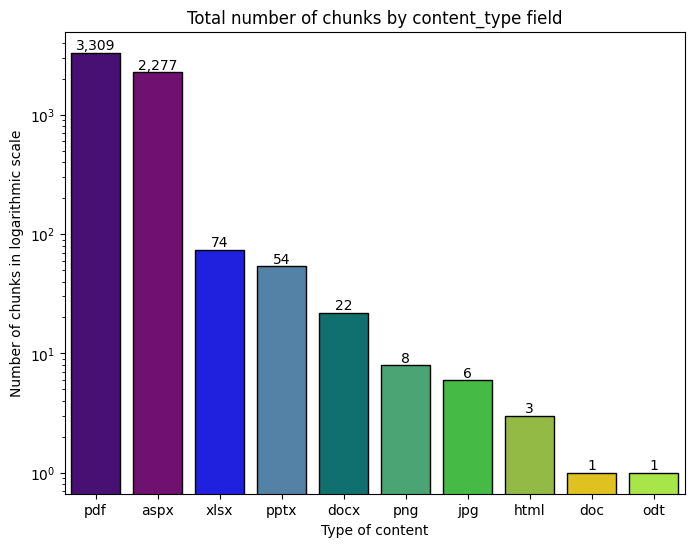

In [30]:
warnings.filterwarnings("ignore")
fig=chunks_per_content()
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)

# The result is the interpretation text from the model
print(interpretation)

In [22]:
def doc_count():
    doc_count_per_type = embeddings_df.groupby('content_type')['document_id'].nunique().reset_index()
    doc_count_per_type.columns = ['content_type', 'doc_count']

    # Sort by doc_count in descending order
    doc_count_per_type = doc_count_per_type.sort_values(by='doc_count', ascending=False)

    # Create the bar plot with seaborn
    fig, ax = plt.subplots(figsize=(10, 6))  # Create the figure and axes

    # Create the bar plot
    sns.barplot(x='content_type', y='doc_count', data=doc_count_per_type, palette='viridis', ax=ax)

    # Set the y-axis to logarithmic scale
    ax.set(yscale='log')

    # Add numeric annotations on each bar
    for p in ax.patches:
        height = p.get_height()  # Get the height of each bar
        ax.annotate(f'{height:,.0f}',  # Format the number
                    (p.get_x() + p.get_width() / 2., height),  # x position at the center of the bar, y position at the top of the bar
                    ha='center', va='center',  # Center the label horizontally and vertically
                    fontsize=10, color='black',  # Font size and color
                    xytext=(0, 5), textcoords='offset points')  # Offset the label slightly upwards

    # Set titles and labels
    ax.set_title('Número total de documentos en función del tipo (campo: content_type)')
    ax.set_xlabel('Tipo de contenido')
    ax.set_ylabel('Número de documentos en escala logarítmica')

    # Rotate x-axis labels if needed (especially useful for long content_type labels)
    plt.xticks(rotation=45, ha='right')

    # Adjust layout to make sure everything fits
    plt.tight_layout()

    # Return the figure
    return fig


El gráfico muestra el número total de documentos en función del tipo de contenido, utilizando una escala logarítmica para el eje y. A continuación, se destacan las principales tendencias y conclusiones:

1. **Predominio de PDFs y ASPX**: Los documentos de tipo PDF son los más numerosos, con un total de 705, seguidos por los documentos de tipo ASPX con 427. Estos dos tipos de documentos son significativamente más comunes que los demás.

2. **Documentos de tipo DOCX y XLSX**: Los documentos de tipo DOCX (22) y XLSX (11) también son relativamente comunes, aunque en menor cantidad comparados con los PDFs y ASPX.

3. **Menor cantidad de otros tipos de documentos**: Los documentos de tipo PNG (8), PPTX (7), JPG (5) y HTML (3) tienen una presencia mucho menor.

4. **Tipos de documentos menos comunes**: Los documentos de tipo DOC y ODT son los menos comunes, con solo 1 documento cada uno.

En resumen, los documentos de tipo PDF y ASPX dominan claramente en número, mientras que otros tipos de d

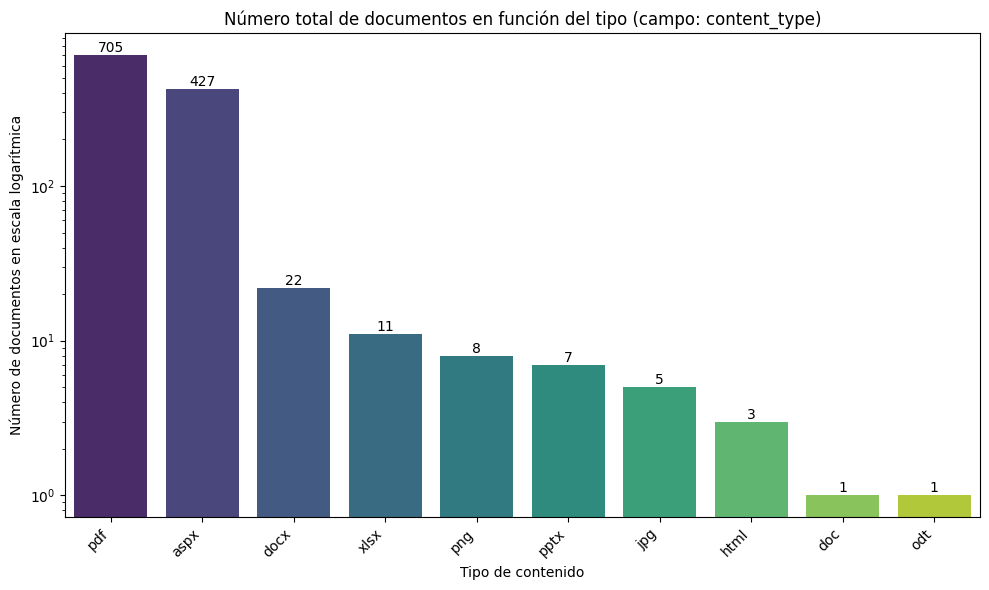

In [30]:
warnings.filterwarnings("ignore")
fig=doc_count()
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)
print(interpretation)

In [25]:
chunks_per_doc = (embeddings_df.groupby(['content_type', 'document_id'])['chunk_id']
                     .count()
                     .reset_index(name='chunk_count'))
    
chunks_stats = (chunks_per_doc.groupby('content_type')['chunk_count']
                   .agg(['mean', 'std'])
                   .round(1)
                   .reset_index())

In [95]:
chunks_stats

,content_type,mean,std
0,aspx,5.3,38.5
1,doc,1.0,NaN
2,docx,1.0,0.0
3,html,1.0,0.0
4,jpg,1.2,0.4
5,odt,1.0,NaN
6,pdf,4.7,7.3
7,png,1.0,0.0
8,pptx,7.7,4.6
9,xlsx,6.7,8.2


In [34]:
def std():
    data = {
        'content_type': ['aspx', 'doc', 'docx', 'html', 'jpg', 'odt', 'pdf', 'png', 'pptx', 'xlsx'],
        'mean': [5.3, 1.0, 1.0, 1.0, 1.2, 1.0, 4.7, 1.0, 7.7, 6.7],
        'std': [38.5, np.nan, 0.0, 0.0, 0.4, np.nan, 7.3, 0.0, 4.6, 8.2]
    }

    # Create dataframe
    df = pd.DataFrame(data)

    # Set content_type order
    content_order = ['pdf', 'aspx', 'xlsx', 'pptx', 'docx', 'png', 'jpg', 'html', 'doc', 'odt']
    df['content_type'] = pd.Categorical(df['content_type'], categories=content_order, ordered=True)

    # Sorting the dataframe based on the defined order
    df = df.sort_values('content_type')

    # Define custom colors to match the original chart
    colors = ['indigo', 'purple', 'blue', 'steelblue', 'teal', 'mediumseagreen', 'limegreen', 'yellowgreen', 'gold', 'greenyellow']

    # Plotting
    fig, ax = plt.subplots(figsize=(9, 6))

    # Bar plot for mean values
    bars = ax.bar(df['content_type'], df['mean'], yerr=df['std'], capsize=5, color=colors, edgecolor='black')

    # Add text for the mean and std values on top of the bars
    for bar, mean, std in zip(bars, df['mean'], df['std']):
        mean_text = f'{mean:.1f}'
        std_text = f'±{std:.1f}' if not np.isnan(std) else ''
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f'{mean_text} {std_text}', ha='center', va='bottom', fontsize=10)

    # Labels and title
    ax.set_xlabel('Content Type')
    ax.set_ylabel('Mean Value')
    ax.set_title('Mean and Standard Deviation by Content Type')

    # Improve layout and appearance
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    # Display plot
    plt.show()


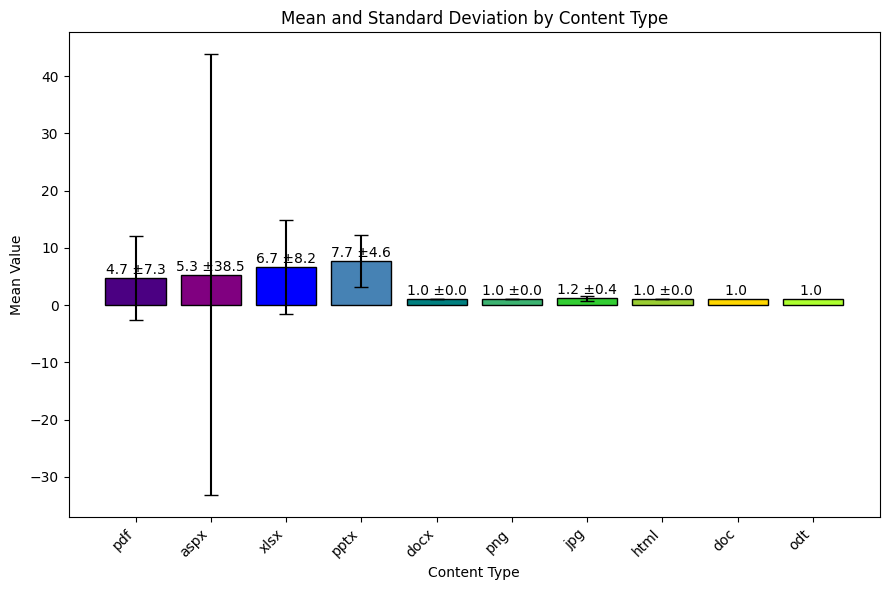

AttributeError: 'NoneType' object has no attribute 'savefig'

In [35]:
warnings.filterwarnings("ignore")
fig=std()
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)
print(interpretation)

# II) Análisis en función de category

Asignamos un color a cada tipo de chunk

In [36]:
color_mapping = {
    'site': '#FFB347',
    'calendar': '#84b6f4',  
    'table': '#77dd77',    
    'document': '#ff6961',      
}
embeddings_df['color'] = embeddings_df['category'].map(color_mapping)

In [136]:
def chunks_per_category():
    chunk_count_per_type = embeddings_df.groupby(['category', 'color'])['chunk_id'].count().reset_index()
    chunk_count_per_type.columns = ['category', 'color', 'chunk_count']
    chunk_count_per_type = chunk_count_per_type.sort_values(by='chunk_count', ascending=False)

    category_colors = dict(zip(chunk_count_per_type['category'], chunk_count_per_type['color']))

    plt.figure(figsize=(12, 8))
    sns.set(style="whitegrid")

    ax = sns.barplot(x='category', y='chunk_count', data=chunk_count_per_type, palette=category_colors, edgecolor= 'black')

    ax.set(yscale='log')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    fontsize=11, color='black', fontweight='bold',
                    xytext=(0, 5), textcoords='offset points')

    ax.set_title('Total number of Chunks by Category', fontsize=16, fontweight='bold')
    ax.set_xlabel('Category', fontsize=14, fontweight='bold')
    ax.set_ylabel('Number of chunks in logarithmic scale', fontsize=14, fontweight='bold')

    plt.xticks(rotation=45, ha='right', fontsize=12)

    plt.tight_layout()

    plt.show()

    return ax.figure


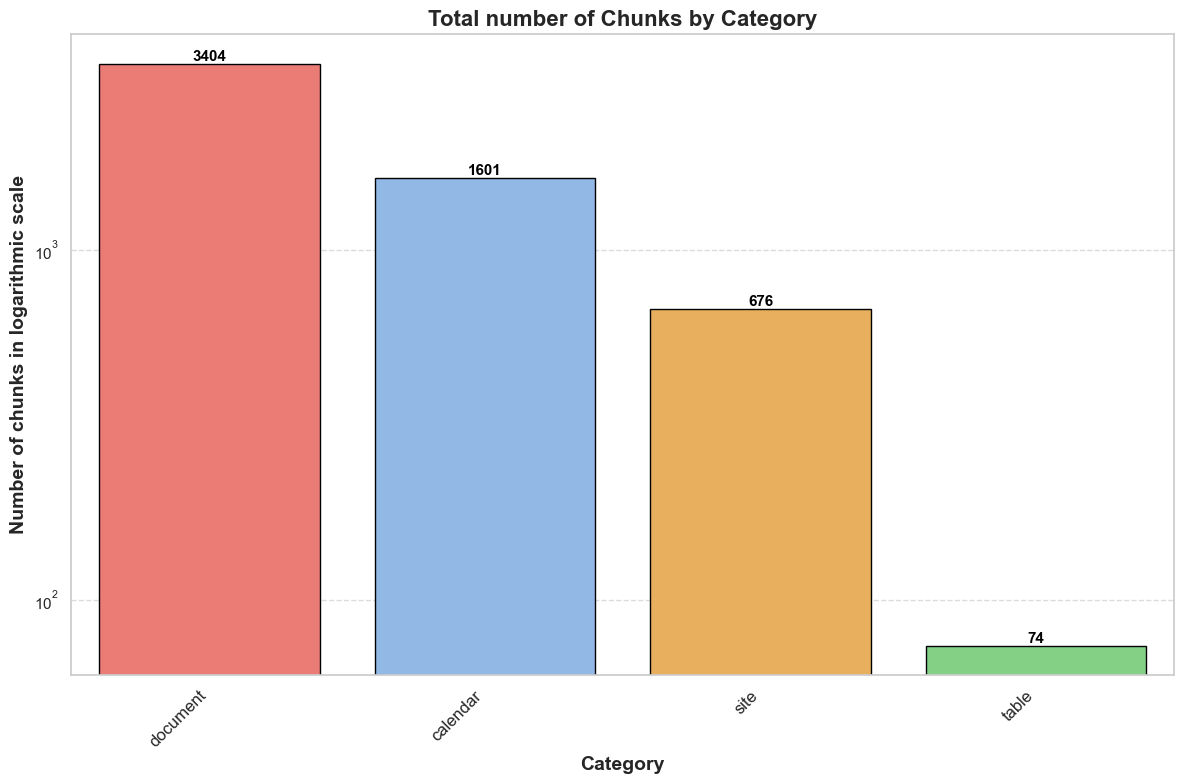

El gráfico muestra el número total de "chunks" (fragmentos) por categoría en una escala logarítmica. Las categorías incluidas son "document", "calendar", "site" y "table".

Principales tendencias y conclusiones:
1. **Documentos**: Esta categoría tiene la mayor cantidad de fragmentos, con un total de 3404, destacándose significativamente sobre las demás.
2. **Calendarios**: La segunda categoría con más fragmentos, con un total de 1601, aunque menos de la mitad en comparación con los documentos.
3. **Sitios**: Ocupa el tercer lugar con 676 fragmentos, mostrando una cantidad considerablemente menor que las dos primeras categorías.
4. **Tablas**: Es la categoría con menos fragmentos, con solo 74, lo que representa una cantidad muy baja en comparación con las otras categorías.

En resumen, los documentos contienen la mayor cantidad de fragmentos, seguidos por los calendarios y los sitios, mientras que las tablas tienen una presencia mínima en términos de fragmentos.


In [137]:
warnings.filterwarnings("ignore")
fig=chunks_per_category()
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)
print(interpretation)

In [41]:
chunk_count_per_type = embeddings_df.groupby(['category'])['chunk_id'].count().reset_index()
# chunk_count_per_type.columns = ['category', 'color', 'chunk_count']
# chunk_count_per_type = chunk_count_per_type.sort_values(by='chunk_count', ascending=False)

In [46]:
chunk_count_per_type
chunk_count_per_type['chunk_id'].sum()

5755

In [142]:
def plot_chunks_per_doc_id():
    # Group by 'category' and 'document_id' to count 'chunk_id' occurrences
    chunk_count_per_doc = embeddings_df.groupby(['category', 'document_id'])['chunk_id'].count().reset_index()
    chunk_count_per_doc.columns = ['category', 'document_id', 'chunk_count']
    
    # Aggregate statistics (mean and standard deviation) by 'category'
    stats_per_category = chunk_count_per_doc.groupby('category')['chunk_count'].agg(['mean', 'std']).reset_index()
    stats_per_category.columns = ['category', 'avg_chunk_count_per_doc', 'std_chunk_count_per_doc']
    
    # Sort the categories by average chunk count in descending order
    stats_per_category = stats_per_category.sort_values(by='avg_chunk_count_per_doc', ascending=False)
    
    # Create a color map for the categories, using the 'color' column from embeddings_df
    unique_categories = stats_per_category['category'].unique()
    color_mapping = {category: color for category, color in zip(embeddings_df['category'], embeddings_df['color']) if category in unique_categories}
    
    # Set up the figure and axis for the plot
    plt.figure(figsize=(12, 7))
    ax = sns.barplot(x='category', y='avg_chunk_count_per_doc', data=stats_per_category, palette=color_mapping, edgecolor='black')
    
    # Annotate the bars with mean ± standard deviation, and optionally add error bars
    for i, row in stats_per_category.iterrows():
        category = row['category']
        avg = row['avg_chunk_count_per_doc']
        std = row['std_chunk_count_per_doc']
        
        # Add annotation text for the mean and standard deviation
        ax.text(i, avg + std, 
                f"{round(avg, 1)} ± {round(std, 1)}", 
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

        # Optionally, add error bars for the standard deviation
        ax.errorbar(i, avg, yerr=std, fmt='none', color='black', capsize=5, elinewidth=1.2)
    
    ax.set_title('Average Chunks per Document by Category (with Standard Deviation)', fontsize=16, fontweight='bold')
    ax.set_xlabel('Category', fontsize=14, fontweight='bold')
    ax.set_ylabel('Average Chunks per Document', fontsize=14, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
    ax.set_ylim(bottom=-25)  # Ensure bars start from zero
    
    # Tight layout to ensure everything fits nicely
    plt.tight_layout()

    # Show the plot
    plt.show()

    return ax.figure

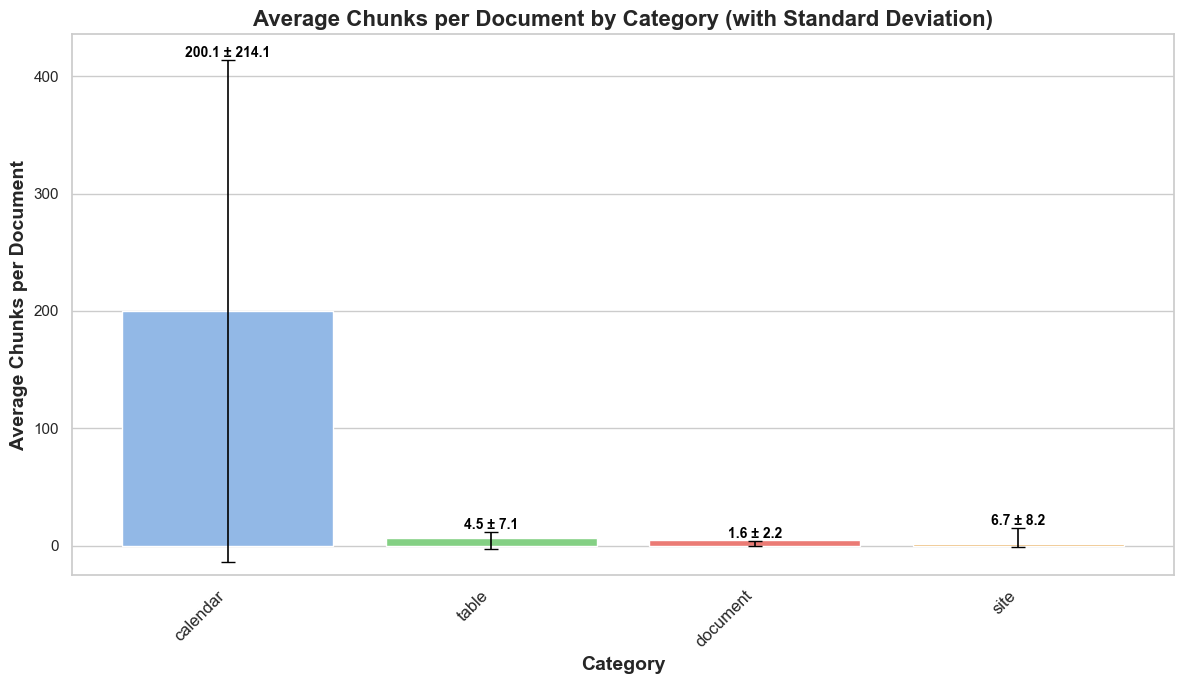

El gráfico muestra el promedio de fragmentos por documento en diferentes categorías, junto con su desviación estándar. Las categorías incluidas son "calendar", "table", "document" y "site".

1. **Calendar**: Tiene un promedio de 200.1 fragmentos por documento, con una desviación estándar de 214.1. Esto indica una gran variabilidad en el número de fragmentos por documento en esta categoría.
2. **Table**: Tiene un promedio de 4.5 fragmentos por documento, con una desviación estándar de 7.1. La variabilidad es menor en comparación con "calendar", pero aún significativa.
3. **Document**: Tiene un promedio de 1.6 fragmentos por documento, con una desviación estándar de 2.2. La variabilidad es relativamente baja.
4. **Site**: Tiene un promedio de 6.7 fragmentos por documento, con una desviación estándar de 8.2. La variabilidad es moderada.

En resumen, la categoría "calendar" tiene el mayor promedio de fragmentos por documento y también la mayor variabilidad, mientras que "document" tiene el

In [73]:
warnings.filterwarnings("ignore")
fig=plot_chunks_per_doc_id()
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)
print(interpretation)

## III) Análisis en función del cluster

Asignamos un número a cada etiqueta

In [178]:
etiquetas_unicas = embeddings_df['etiqueta_asignada'].unique()
etiqueta_dict = {etiqueta: i for i, etiqueta in enumerate(etiquetas_unicas)}

# Create a DataFrame for the table with 2 columns
table = pd.DataFrame(list(etiqueta_dict.items()), columns=['Etiqueta', 'Número'])

# Save the table as a CSV file
table_file_path = 'etiquetas_dict_table.xlsx'
table.to_excel(table_file_path, index=False)
print(table)

                                             Etiqueta  Número
0   Envío a domicilio, gestión de pedidos, modific...       0
1   Responsabilidad documental, estructuras de tab...       1
2   Clientes, gestión de casos, encuestas de satis...       2
3   Venta de entradas, proceso de compra, identifi...       3
4   Tarifa plana, ventajas empleados, envío gratis...       4
5   Devolución iva, tarjeta regalo, atención clien...       5
6   Devoluciones cupones, ajustes promocionales, c...       6
7   Encargos, gestión de pedidos, atención al clie...       7
8   Archivos transferencias, gestión de abonos, in...       8
9   Compatibilidad de dispositivos, requisitos de ...       9
10  Teletrabajo, conexión audio, telemarketing, ph...      10
11  Reclamaciones cliente, derechos arco, gestión ...      11
12  Migración salesforce, flujos logística, gestió...      12
13  Gestión documental, observaciones gestión, his...      13
14  Promociones supermercado, actualización calend...      14
15  Merc

Visualización por tipo de documento y cluster

In [126]:
def plot_proportions_with_seaborn():
    grouped = embeddings_df.groupby(['etiqueta_asignada', 'category']).size().reset_index(name='count')
    grouped['total'] = grouped.groupby('etiqueta_asignada')['count'].transform('sum')
    grouped['proportion'] = (grouped['count'] / grouped['total']) * 100
    grouped['proportion'] = grouped['proportion'].round(1)
    grouped['etiqueta_numero'] = grouped['etiqueta_asignada'].map(etiqueta_dict)
    grouped = grouped.sort_values(by='etiqueta_numero')

    color_mapping = {
        'document': '#ff6961',
        'site': '#FFB347',
        'calendar': '#84b6f4',
        'table': '#77dd77'
    }

    pivoted = grouped.pivot_table(index='etiqueta_numero', columns='category', values='proportion', aggfunc='sum').fillna(0)

    ax = pivoted.plot(kind='bar', stacked=True, figsize=(14, 8), color=[color_mapping[cat] for cat in pivoted.columns], edgecolor='black', width=0.85)

    plt.title('Category Proportions for each Cluster', fontsize=18, fontweight='bold')
    plt.xlabel('Cluster', fontsize=16, labelpad=10)
    plt.ylabel('Proportion of chunks (%)', fontsize=16, labelpad=10)
    plt.xticks(ticks=range(len(etiqueta_dict)), labels=[str(val) for val in etiqueta_dict.values()], fontsize=14, rotation=45, ha='right')
    plt.yticks(fontsize=14)
    plt.legend(title='Category', title_fontsize=14, fontsize=12, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

    plt.tight_layout()
    plt.show()

    return ax.figure


In [95]:
def fig_to_image2(fig):
    """Convert a Matplotlib figure to a numpy array using Agg backend."""
    # Use the 'Agg' backend for rendering the figure to a canvas
    from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

    # Create a canvas from the figure
    canvas = FigureCanvas(fig)
    
    # Draw the figure on the canvas (this renders the plot)
    canvas.draw()
    
    # Convert the canvas to a numpy array (RGB values)
    # canvas.renderer.buffer_rgba() returns the RGBA data of the figure
    image_array = np.array(canvas.renderer.buffer_rgba())
    
    return image_array


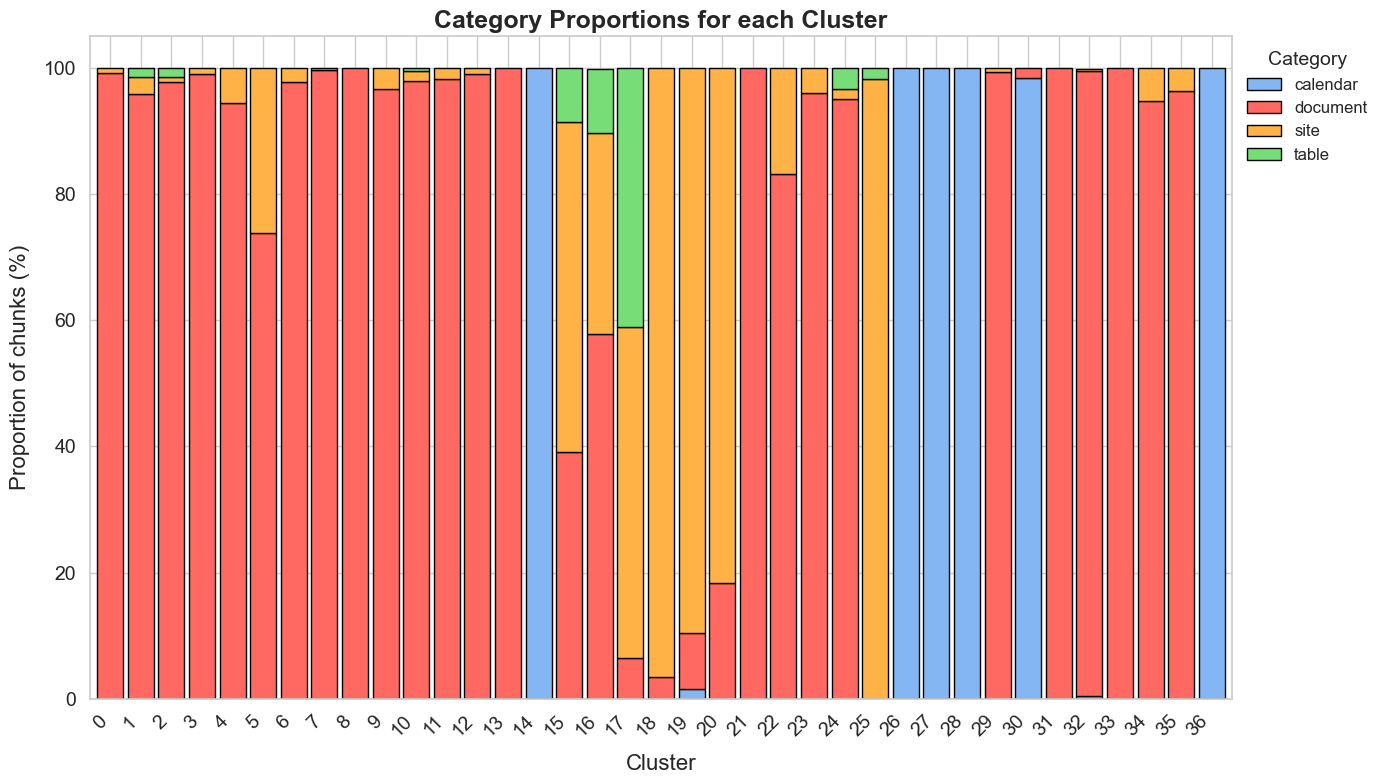

El gráfico de barras apiladas muestra las proporciones de diferentes categorías (calendar, document, site, table) en cada uno de los 36 clusters. A continuación se destacan las principales tendencias y conclusiones:

1. **Predominio de la categoría "document"**: La categoría "document" (en rojo) es la más predominante en la mayoría de los clusters. En muchos clusters, como el 0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35 y 36, esta categoría representa casi el 100% de los datos.

2. **Clusters con mayor diversidad**: Algunos clusters muestran una mayor diversidad de categorías. Por ejemplo:
   - El cluster 7 tiene una mezcla de "document" y "site".
   - El cluster 16 tiene una combinación de "document", "site" y "table".
   - El cluster 17 tiene una mezcla de "document" y "site".
   - El cluster 18 tiene una combinación de "document", "site" y "calendar".
   - El cluster 19 tiene una mezcla de "document", "site" y "tab

In [127]:
fig=plot_proportions_with_seaborn()
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)
print(interpretation)

Distribución de etiquetas

In [59]:
color_mapping = {
    'site': '#FFB347',
    'calendar': '#84b6f4',  
    'table': '#77dd77',    
    'document': '#ff6961',      
}
embeddings_df['color'] = embeddings_df['category'].map(color_mapping)

In [132]:
def plot_chunk_counts_with_annotations():
    # Group by cluster (etiqueta_asignada) and category, then count the chunks
    grouped = embeddings_df.groupby(['etiqueta_asignada', 'category']).size().reset_index(name='count')
    grouped['etiqueta_numero'] = grouped['etiqueta_asignada'].map(etiqueta_dict)
    grouped = grouped.sort_values(by='etiqueta_numero')

    # Color mapping for the categories
    color_mapping = {
        'document': '#ff6961',
        'site': '#FFB347',
        'calendar': '#84b6f4',
        'table': '#77dd77'
    }

    # Pivot table to prepare data for plotting
    pivoted = grouped.pivot_table(index='etiqueta_numero', columns='category', values='count', aggfunc='sum').fillna(0)

    # Plotting the stacked bar chart
    ax = pivoted.plot(kind='bar', stacked=True, figsize=(14, 8), color=[color_mapping[cat] for cat in pivoted.columns], edgecolor='black', width=0.85)

    # Add annotations (counts) to the plot
    for i, cluster in enumerate(pivoted.index):  # Loop through clusters
        cumulative_sum = 0
        for category in pivoted.columns:  # Loop through categories
            value = pivoted.loc[cluster, category]
            if value > 0:
                cumulative_sum += value
                plt.text(
                    i, cumulative_sum - value / 2,  # Position of the text
                    f'{int(value)}',  # Text to display
                    ha='center', va='center', fontsize=12, color='black'
                )

    # Set titles and labels
    plt.title('Chunk Counts by Category for Each Cluster', fontsize=18, fontweight='bold')
    plt.xlabel('Cluster', fontsize=16, labelpad=10)
    plt.ylabel('Number of Chunks', fontsize=16, labelpad=10)
    plt.xticks(ticks=range(len(etiqueta_dict)), labels=[str(val) for val in etiqueta_dict.values()], fontsize=14, rotation=45, ha='right')
    plt.yticks(fontsize=14)

    # Add legend
    plt.legend(title='Category', title_fontsize=14, fontsize=12, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

    # Adjust layout
    plt.tight_layout()
    plt.show()

    return ax.figure


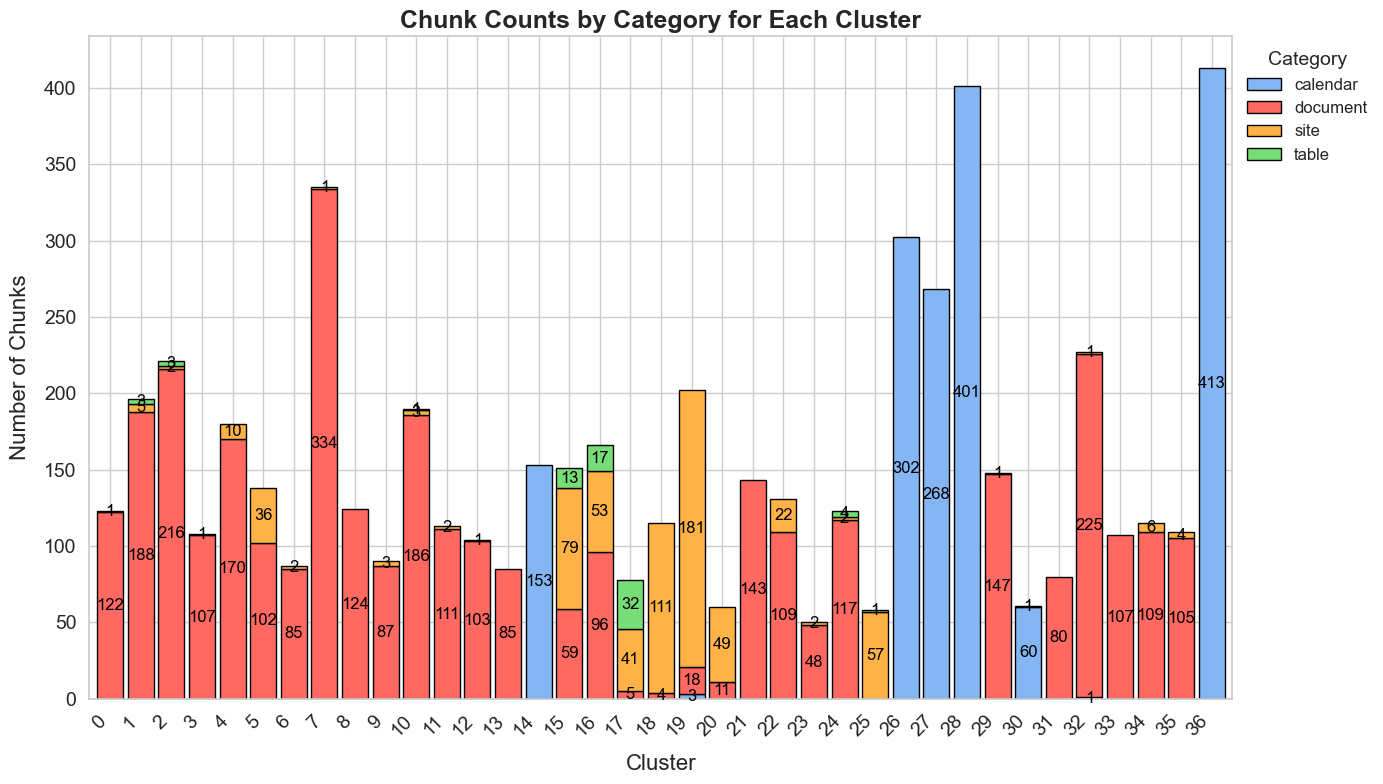

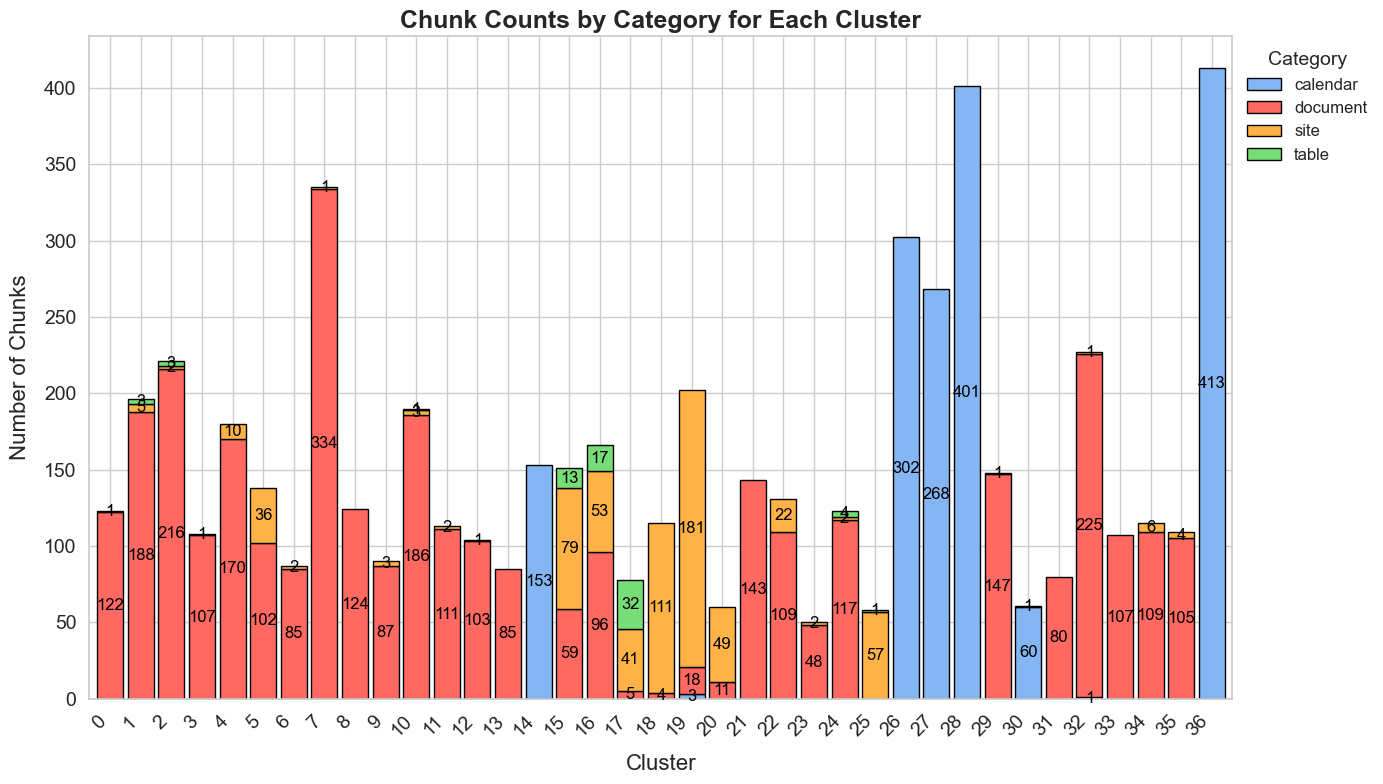

In [133]:
plot_chunk_counts_with_annotations()

In [58]:
def docs_por_clus_cat(embeddings_df):    
    grouped = embeddings_df.groupby('document_id')['etiqueta_numero'].nunique().reset_index()
    grouped['All_Same_Cluster'] = grouped['etiqueta_numero'] == 1
    embeddings_df = embeddings_df.merge(
        grouped[['document_id', 'All_Same_Cluster']], 
        on='document_id', 
        how='left'
    )
    count_status = (
        embeddings_df.groupby(['etiqueta_numero', 'All_Same_Cluster', 'category'])['document_id']
        .nunique()
        .reset_index(name='Document_Count')
    )
    plt.figure(figsize=(14, 8))
    count_status_pivot = count_status.pivot_table(
        index='etiqueta_numero', 
        columns='category', 
        values='Document_Count', 
        fill_value=0
    )
    color_mapping = embeddings_df.drop_duplicates('category')[['category', 'color']].set_index('category')['color'].to_dict()
    ax = count_status_pivot.plot(kind='bar', stacked=True, figsize=(14, 8), color=[color_mapping.get(cat) for cat in count_status_pivot.columns])
    #ax.set_yscale('log')
    plt.title('Total number of documents per cluster and category', fontsize=16, fontweight='bold')
    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel('Number of documents', fontsize=14)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Category', fontsize=12, title_fontsize=14)
    plt.tight_layout()
    return plt.gcf()


El gráfico muestra el número total de documentos por clúster y categoría. Las categorías están representadas por diferentes colores: azul para "calendar", rojo para "document", amarillo para "site" y verde para "table".

Algunas observaciones clave son:

1. **Predominio de la categoría "document"**: La mayoría de los clústeres tienen una gran cantidad de documentos en la categoría "document" (rojo). Esto es especialmente notable en los clústeres 0, 1, 2, 4, 5, 6, 7, 8, 10, 16, 20, 21, 24, 29, 31, 32, 33 y 36.

2. **Clústeres con alta cantidad de documentos**: Los clústeres 2, 16, 18 y 32 tienen un número significativamente alto de documentos en comparación con otros clústeres. El clúster 18 destaca particularmente con una gran cantidad de documentos en la categoría "site" (amarillo).

3. **Diversidad de categorías**: Algunos clústeres muestran una diversidad de categorías. Por ejemplo, el clúster 2 tiene documentos en todas las categorías (calendar, document, site y table), mientras qu

<Figure size 1400x800 with 0 Axes>

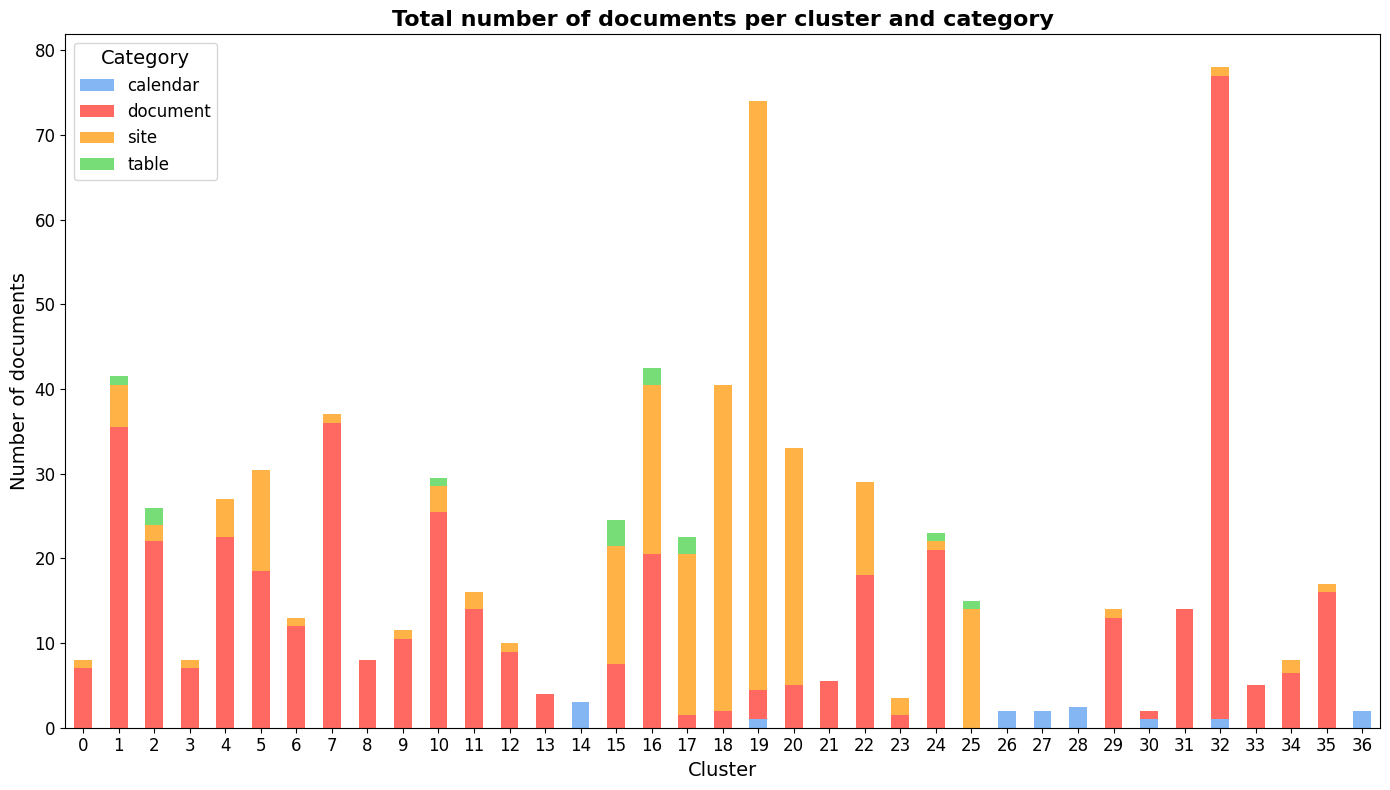

In [59]:
fig=docs_por_clus_cat(embeddings_df)
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)
print(interpretation)

In [115]:
def avg_chunks_per_cluster_with_categories(embeddings_df):
    # Calculate the number of chunks per document
    chunks_per_doc = embeddings_df.groupby('document_id').size().reset_index(name='Chunk_Count')
    
    # Merge the chunk counts back into the main DataFrame
    embeddings_df = embeddings_df.merge(chunks_per_doc, on='document_id', how='left')
    
    # Calculate the average chunks per category and cluster
    avg_chunks = (
        embeddings_df.groupby(['etiqueta_numero', 'category'])['Chunk_Count']
        .mean()
        .reset_index(name='Avg_Chunks')
    )
    
    # Pivot for plotting
    avg_chunks_pivot = avg_chunks.pivot_table(
        index='etiqueta_numero', 
        columns='category', 
        values='Avg_Chunks', 
        fill_value=0
    )
    
    # Get the colors for each category
    color_mapping = embeddings_df.drop_duplicates('category')[['category', 'color']].set_index('category')['color'].to_dict()
    
    # Plot a stacked bar chart
    avg_chunks_pivot.plot(
        kind='bar', 
        stacked=True, 
        figsize=(12, 7), 
        color=[color_mapping.get(cat) for cat in avg_chunks_pivot.columns]
    )
    
    # Add labels and title
    plt.title('Average Chunks per Document_ID for Each Cluster (by Category)', fontsize=16, fontweight='bold')
    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel('Average Chunks per Document', fontsize=14)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Category', fontsize=12, title_fontsize=14)
    plt.tight_layout()
    
    return plt.gcf()

# Example usage:
# avg_chunks_per_cluster_with_categories(embeddings_df)

In [122]:
# Ensure the columns exist before trying to drop them
columns_to_drop = ['Chunk_Count_x', 'Chunk_Count_y', 'Chunk_Count']
embeddings_df = embeddings_df.drop(columns=[col for col in columns_to_drop if col in embeddings_df.columns])


In [134]:
def plot_avg_chunks_per_document_with_colors(embeddings_df):
    # Step 1: Calculate the number of chunks per document
    chunks_per_doc = embeddings_df.groupby('document_id').size().reset_index(name='Chunk_Count')

    # Step 2: Merge the chunk counts back into the main DataFrame
    embeddings_df = embeddings_df.merge(chunks_per_doc, on='document_id', how='left')

    # Step 3: Calculate the average chunks per document for each cluster
    avg_chunks = (
        embeddings_df.groupby(['etiqueta_numero', 'document_id'])['Chunk_Count']
        .mean()
        .reset_index(name='Avg_Chunks')
    )

    # Step 4: Assign the corresponding cluster and color
    avg_chunks = avg_chunks.merge(
        embeddings_df[['document_id', 'color']].drop_duplicates(), 
        on='document_id', 
        how='left'
    )

    # Step 5: Calculate the average chunks for each cluster
    cluster_avg = avg_chunks.groupby('etiqueta_numero')['Avg_Chunks'].mean().reset_index()

    # Step 6: Assign a color to each cluster based on the first document's color
    cluster_avg = cluster_avg.merge(
        avg_chunks[['etiqueta_numero', 'color']].drop_duplicates('etiqueta_numero'), 
        on='etiqueta_numero', 
        how='left'
    )

    # Step 7: Plot a bar chart
    fig, ax = plt.subplots(figsize=(14, 8))
    bars = ax.bar(
        cluster_avg['etiqueta_numero'], 
        cluster_avg['Avg_Chunks'], 
        color=cluster_avg['color'], 
        edgecolor='black', 
        width=0.8
    )

    # Step 8: Add annotations (average values) on top of each bar
    for bar, avg in zip(bars, cluster_avg['Avg_Chunks']):
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            bar.get_height() + 0.05, 
            f'{avg:.1f}', 
            ha='center', 
            va='bottom', 
            fontsize=12, 
            fontweight='bold'
        )

    # Step 9: Set chart labels and title
    plt.title('Average Chunks per Document_ID for Each Cluster', fontsize=18, fontweight='bold')
    plt.xlabel('Cluster', fontsize=16, labelpad=10)
    plt.ylabel('Average Chunks per Document', fontsize=16, labelpad=10)
    plt.xticks(ticks=cluster_avg['etiqueta_numero'], fontsize=14)
    plt.yticks(fontsize=14)

    # Adjust layout
    plt.tight_layout()
    plt.show()

    return fig


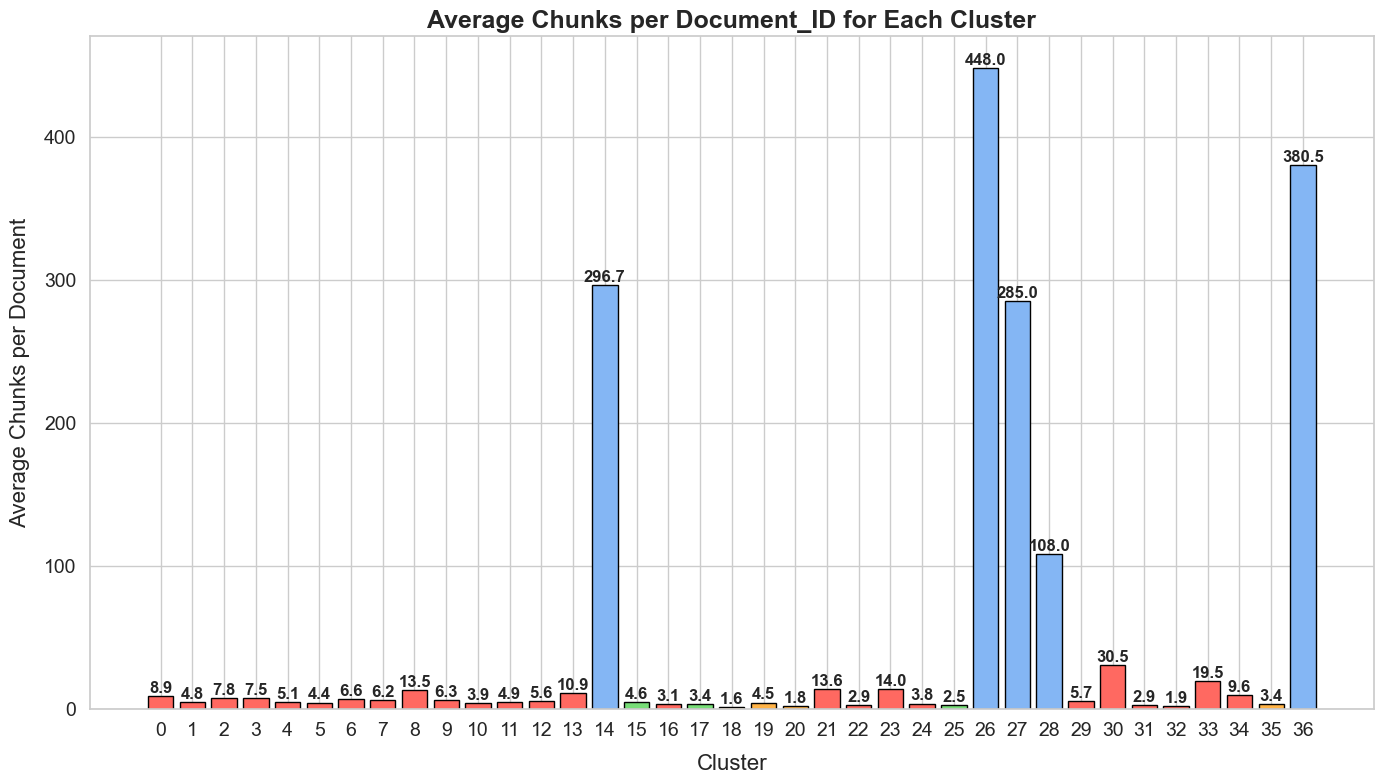

El gráfico muestra el promedio de fragmentos por documento para cada clúster. La mayoría de los clústeres tienen un promedio bajo de fragmentos por documento, con valores que oscilan entre 1.4 y 19.5. Sin embargo, hay algunos clústeres que destacan significativamente con promedios mucho más altos:

- Clúster 14: 296.7 fragmentos por documento.
- Clúster 26: 448.0 fragmentos por documento.
- Clúster 27: 285.0 fragmentos por documento.
- Clúster 28: 108.0 fragmentos por documento.
- Clúster 35: 380.5 fragmentos por documento.

Estos clústeres tienen promedios de fragmentos por documento considerablemente más altos en comparación con los demás, lo que sugiere que los documentos en estos clústeres son mucho más fragmentados.


In [135]:
fig=plot_avg_chunks_per_document_with_colors(embeddings_df)
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)
print(interpretation)

Para cada cluster, cuantos chunks pertenecen al mismo documento? (solo documentos con más de un chunk)

In [86]:
def chunks_por_clus_cat_seaborn(embeddings_df):
    columns_to_remove = [
        'center_category_x', 'is_outlier',
        'All_Same_Cluster_x', 'All_Same_Cluster_y', 'All_Same_Cluster',
        'center_category_y', 'All_Same_Cluster_Grouped_x', 
        'All_Same_Cluster_Grouped_y', 'All_Same_Cluster_Grouped'
    ]
    embeddings_df.drop(columns=columns_to_remove, inplace=True, errors='ignore')

    grouped = embeddings_df.groupby('document_id')['chunk_id'].nunique().reset_index()
    grouped = grouped[grouped['chunk_id'] > 1]
    embeddings_df = embeddings_df[embeddings_df['document_id'].isin(grouped['document_id'])]

    grouped = embeddings_df.groupby('document_id')['etiqueta_numero'].nunique().reset_index()
    grouped['All_Same_Cluster'] = grouped['etiqueta_numero'] == 1

    embeddings_df = embeddings_df.merge(
        grouped[['document_id', 'All_Same_Cluster']], 
        on='document_id', 
        how='left'
    )

    count_status = (
        embeddings_df.groupby(['etiqueta_numero', 'All_Same_Cluster', 'category'])
        .size()
        .reset_index(name='Document_Count')
    )

    unique_clusters = embeddings_df['etiqueta_numero'].unique()
    n_clusters = len(unique_clusters)

    n_cols = 7
    n_rows = (n_clusters + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3 * n_rows))
    axes = axes.flatten()

    for i, cluster in enumerate(unique_clusters):
        ax = axes[i]
        cluster_data = count_status[count_status['etiqueta_numero'] == cluster]
        
        sns.barplot(
            data=cluster_data,
            x='All_Same_Cluster',
            y='Document_Count',
            hue='category',
            ax=ax,
            dodge=False,
            palette=embeddings_df.drop_duplicates('category')[['category', 'color']].set_index('category')['color'].to_dict(),
            legend=False  # Remove legend from each subplot
        )
        
        ax.set_title(f'Cluster {cluster}', fontsize=14, fontweight='bold')
        ax.set_ylabel('Número de chunks', fontsize=12)
        ax.set_xlabel('Mismo Cluster', fontsize=12)
        ax.set_facecolor('#f5f5f5')  # Light background color for each subplot
        ax.tick_params(axis='both', labelsize=10)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.suptitle('Chunks pertenecientes al mismo documento por cada cluster', fontsize=18, y=1.02, fontweight='bold')
    
    handles, labels = [], []
    for ax in axes:
        for handle, label in zip(*ax.get_legend_handles_labels()):
            if label not in labels:
                handles.append(handle)
                labels.append(label)
    
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Categoría', fontsize=12)
    plt.tight_layout(pad=3.0)
    
    return plt.gcf()


El gráfico muestra la distribución de "chunks" (fragmentos de datos) que pertenecen al mismo documento para cada uno de los 36 clusters. Cada subgráfico representa un cluster y está dividido en dos categorías: "False" y "True", indicando si los chunks pertenecen o no al mismo documento.

### Principales tendencias y conclusiones:

1. **Clusters con alta cohesión (mayoría "True")**:
   - Clusters como el 0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 22, 23, 24, 25, 30, 31, 32, 33 y 34 tienen una mayoría de chunks que pertenecen al mismo documento. Esto sugiere que estos clusters son bastante cohesivos y agrupan datos que provienen del mismo origen.

2. **Clusters con baja cohesión (mayoría "False")**:
   - Clusters como el 7, 14, 16, 17, 18, 19, 20, 21, 26, 27, 28, 29 y 35 tienen una mayoría de chunks que no pertenecen al mismo documento. Esto indica que estos clusters son más heterogéneos y agrupan datos de diferentes orígenes.

3. **Clusters mixtos**:
   - Algunos clusters, como el 1

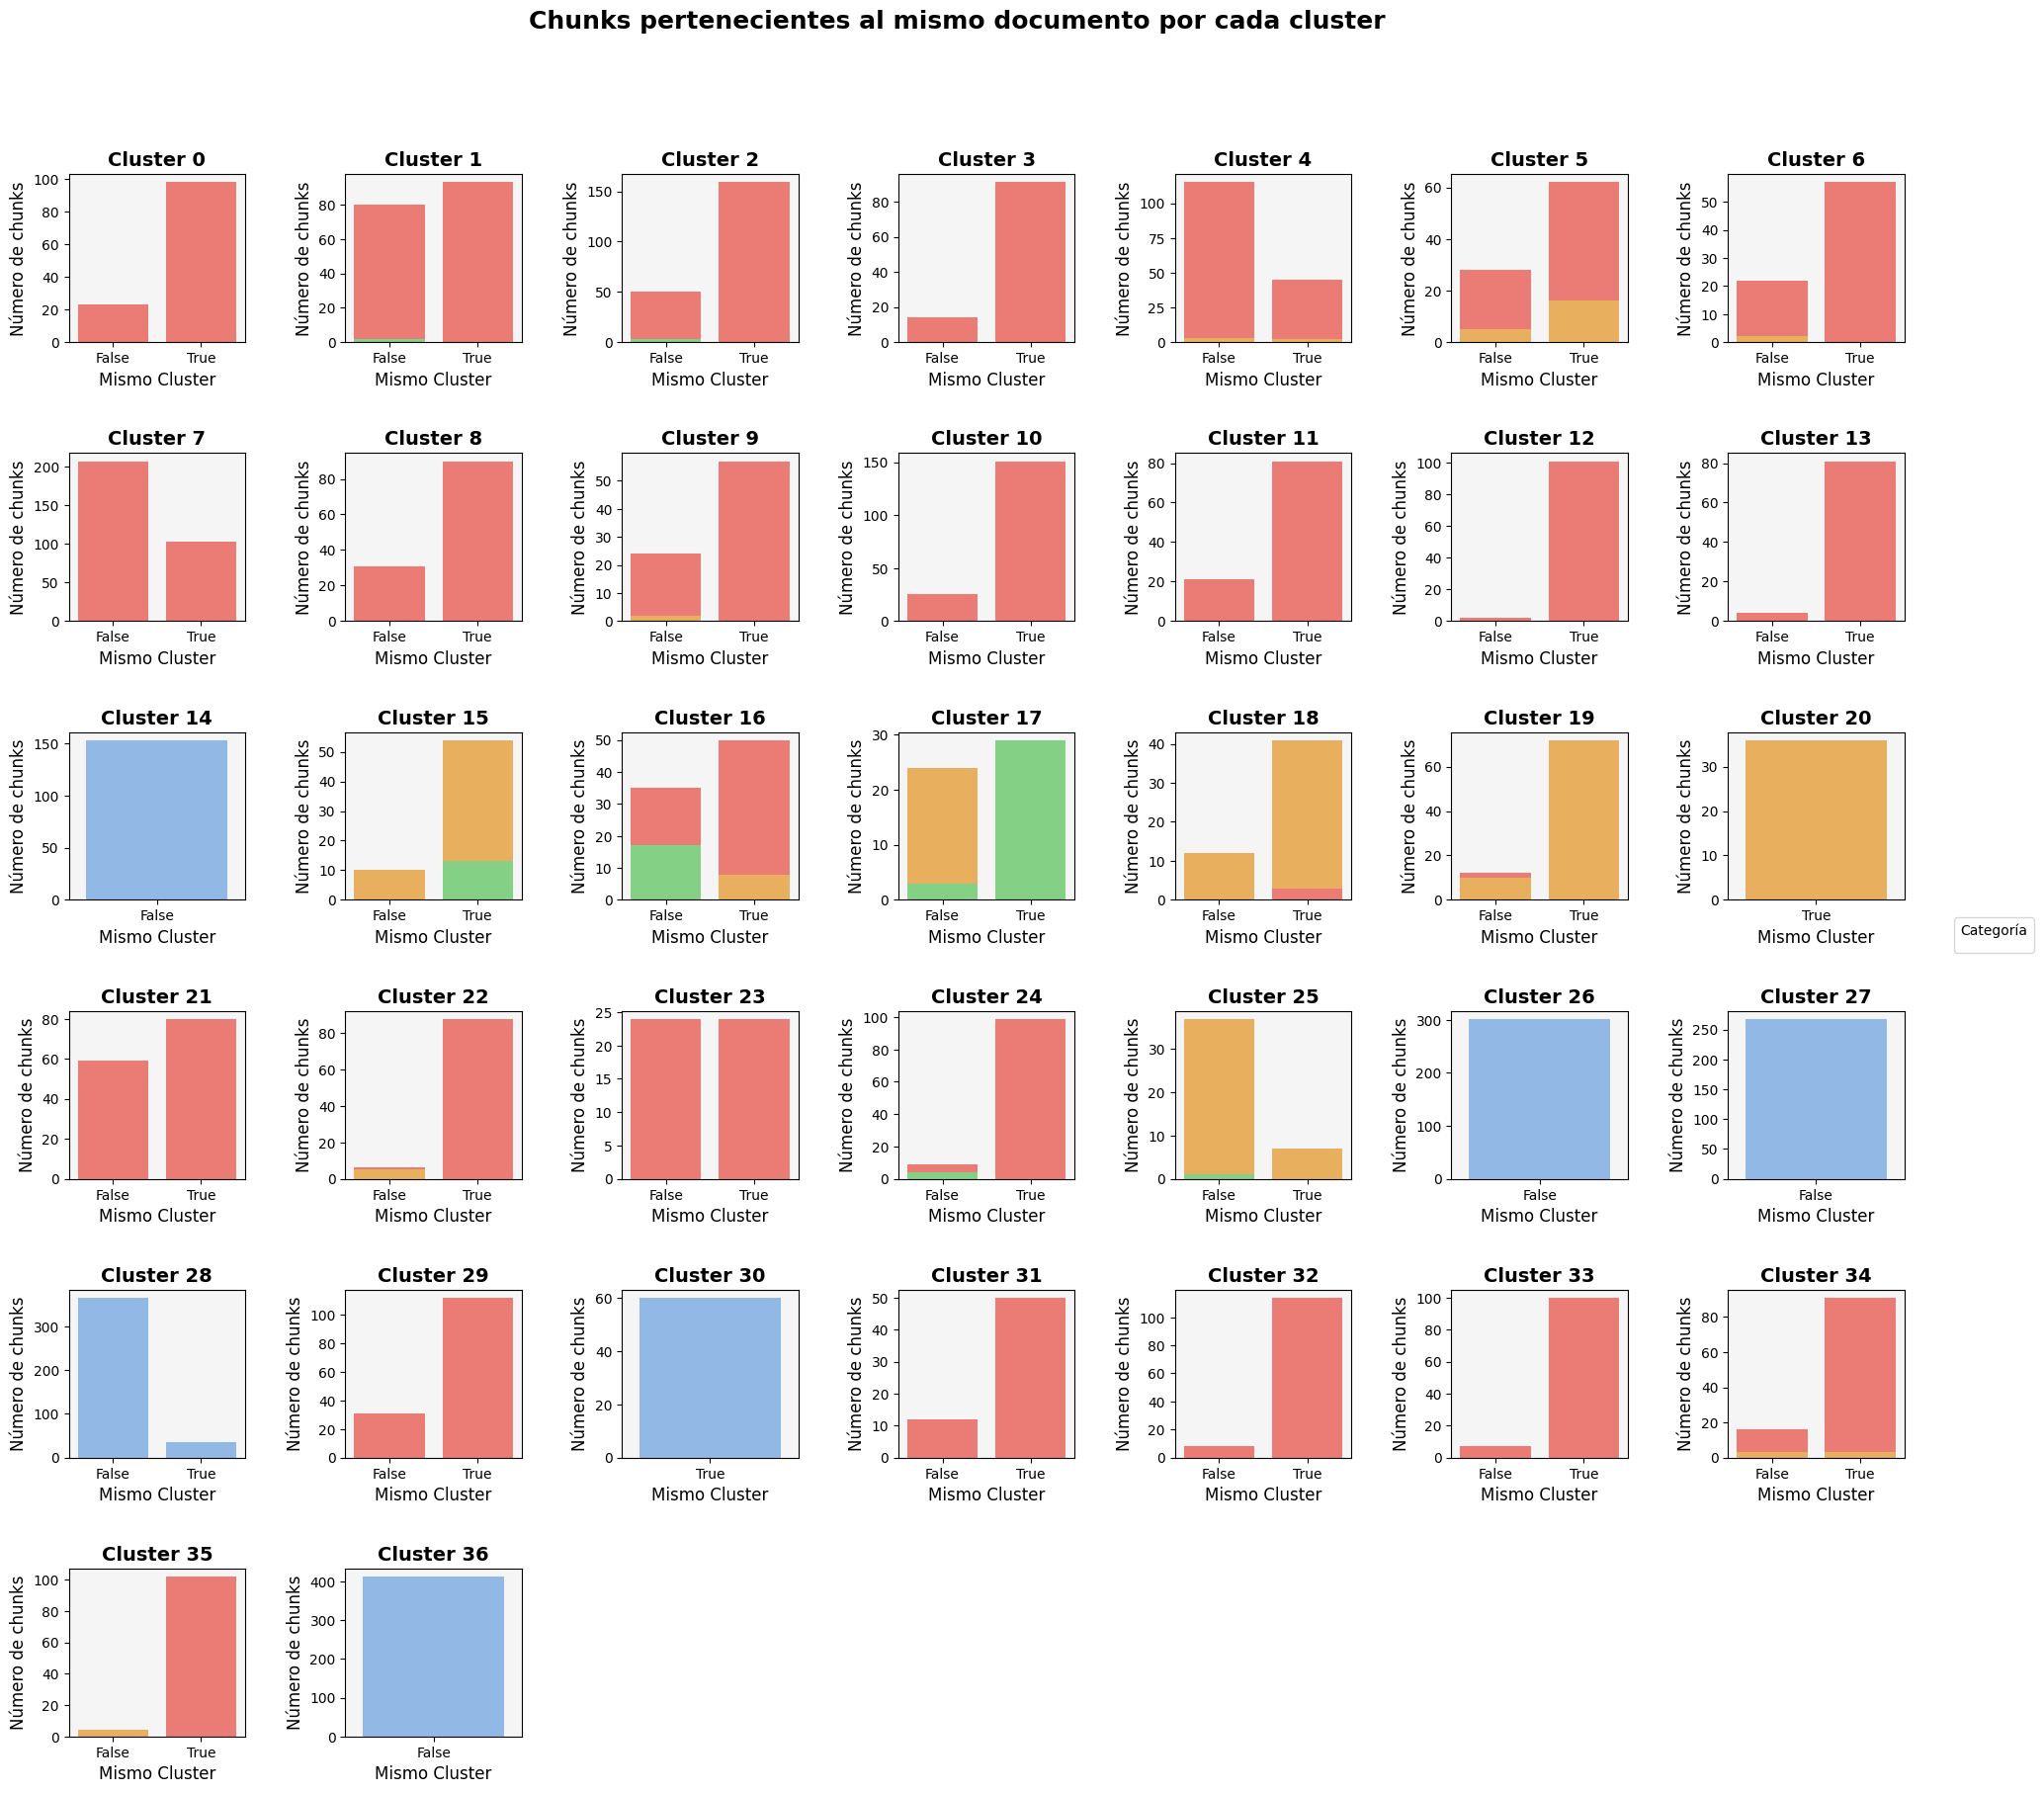

In [55]:
fig=chunks_por_clus_cat_seaborn(embeddings_df)
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)
print(interpretation)

1) Coger los documentos TRUE

In [236]:
def docs_por_clus_cat_seaborn_and_extract(embeddings_df):
    # Eliminar las columnas innecesarias
    columns_to_remove = [
        'center_category_x', 'is_outlier',
        'All_Same_Cluster_x', 'All_Same_Cluster_y', 'All_Same_Cluster',
        'center_category_y', 'All_Same_Cluster_Grouped_x', 
        'All_Same_Cluster_Grouped_y', 'All_Same_Cluster_Grouped'
    ]
    embeddings_df.drop(columns=columns_to_remove, inplace=True, errors='ignore')

    # Agrupar por 'document_id' y contar los clusters únicos
    grouped = embeddings_df.groupby('document_id')['chunk_id'].nunique().reset_index()
    
    # Filtrar documentos que tienen más de 1 chunk_id
    grouped = grouped[grouped['chunk_id'] > 1]
    
    # Merge el filtro de 'document_id' con el dataframe original
    embeddings_df = embeddings_df[embeddings_df['document_id'].isin(grouped['document_id'])]

    # Agrupar nuevamente por 'document_id' y contar los clusters únicos
    grouped = embeddings_df.groupby('document_id')['etiqueta_numero'].nunique().reset_index()
    grouped['All_Same_Cluster'] = grouped['etiqueta_numero'] == 1

    # Merge el flag de 'All_Same_Cluster' de vuelta al dataframe original
    embeddings_df = embeddings_df.merge(
        grouped[['document_id', 'All_Same_Cluster']], 
        on='document_id', 
        how='left'
    )

    # Filtrar solo aquellos documentos donde 'All_Same_Cluster' es True
    documents_with_same_cluster = embeddings_df[embeddings_df['All_Same_Cluster'] == True]

    # Guardar las variables de estos documentos (se puede almacenar como DataFrame o exportar a un archivo)
    # Aquí guardamos en un nuevo DataFrame
    extracted_data = documents_with_same_cluster.copy()

    return extracted_data


In [237]:
data_documents_true = docs_por_clus_cat_seaborn_and_extract(embeddings_df)

2) Coger los chunks en FALSE

In [228]:
def chunks_por_clus_cat_seaborn_and_extract(embeddings_df):
    # Eliminar las columnas innecesarias
    columns_to_remove = [
        'center_category_x', 'is_outlier',
        'All_Same_Cluster_x', 'All_Same_Cluster_y', 'All_Same_Cluster',
        'center_category_y', 'All_Same_Cluster_Grouped_x', 
        'All_Same_Cluster_Grouped_y', 'All_Same_Cluster_Grouped'
    ]
    embeddings_df.drop(columns=columns_to_remove, inplace=True, errors='ignore')

    # Agrupar por 'document_id' y contar los clusters únicos
    grouped = embeddings_df.groupby('document_id')['chunk_id'].nunique().reset_index()
    
    # Filtrar documentos que tienen más de 1 chunk_id
    grouped = grouped[grouped['chunk_id'] > 1]
    
    # Merge el filtro de 'document_id' con el dataframe original
    embeddings_df = embeddings_df[embeddings_df['document_id'].isin(grouped['document_id'])]

    # Agrupar nuevamente por 'document_id' y contar los clusters únicos
    grouped = embeddings_df.groupby('document_id')['etiqueta_numero'].nunique().reset_index()
    grouped['All_Same_Cluster'] = grouped['etiqueta_numero'] == 1

    # Merge el flag de 'All_Same_Cluster' de vuelta al dataframe original
    embeddings_df = embeddings_df.merge(grouped[['document_id', 'All_Same_Cluster']], 
        on='document_id', 
        how='left')

    # Filtrar solo aquellos documentos donde 'All_Same_Cluster' es False
    documents_with_dist_cluster = embeddings_df[embeddings_df['All_Same_Cluster'] == False]

    # Guardar las variables de estos documentos (se puede almacenar como DataFrame o exportar a un archivo)
    # Aquí guardamos en un nuevo DataFrame
    extracted_data = documents_with_dist_cluster.copy()


    return extracted_data


In [229]:
data_chunks_false = chunks_por_clus_cat_seaborn_and_extract(embeddings_df)

### Cálculo de valores atípicos

3) Local Outlier Factor

It produces an anomaly score that represents data points which are outliers in the data set. It does this by measuring the local density deviation of a given data point with respect to the data points near it. Working of LOF: Local density is determined by estimating distances between data points that are neighbors (k-nearest neighbors). So for each data point, local density can be calculated. By comparing these we can check which data points have similar densities and which have a lesser density than its neighbors. The ones with the lesser densities are considered as the outliers. 
https://www.geeksforgeeks.org/local-outlier-factor/

In [148]:


# Generate a custom palette with 37 distinct colors using seaborn
custom_palette = sns.color_palette("Set3", 12) + sns.color_palette("Set2", 8) + sns.color_palette("tab20", 17)

# Ensure the number of colors matches exactly 37
assert len(custom_palette) == 37, f"The custom palette should contain 37 colors, but it contains {len(custom_palette)} colors."



In [149]:
def LOF():
    def plot_boxplots_and_identify_outliers(cluster_data, etiqueta_numero, contamination):
        # Fit Local Outlier Factor
        tam = len(cluster_data)
        neig = abs(tam * 0.25)  # Calculate number of neighbors
        neig = int(neig)
        lof = LocalOutlierFactor(n_neighbors=neig, contamination=contamination)
        outlier_labels = lof.fit_predict(cluster_data)
        
        # Identify inliers and outliers
        is_outlier = outlier_labels == -1
        num_outliers = np.sum(is_outlier)
        
        # Create a DataFrame for plotting
        distances = lof.negative_outlier_factor_  # Get the negative outlier factor for distances
        data_to_plot = pd.DataFrame({'Distancia': -distances, 'Cluster': etiqueta_numero})
        
        return data_to_plot, num_outliers, is_outlier

    # Assume 'embeddings_df' is your DataFrame with cluster labels
    contamination = 'auto'  # Adjust contamination as needed

    # Prepare a list to gather all data and a dictionary to count outliers
    all_data = []
    outlier_counts = {}

    # Create an array to store outlier information
    all_outlier_labels = []

    # Generate boxplots and count outliers for each cluster
    for idx, label in enumerate(embeddings_df['etiqueta_numero'].unique()):
        cluster_data = np.array(embeddings_df[embeddings_df['etiqueta_numero'] == label]['content_vector_norm'].tolist())
        data_to_plot, num_outliers, is_outlier = plot_boxplots_and_identify_outliers(cluster_data, label, contamination)

        # Append data for the current cluster to the list
        all_data.append(data_to_plot)

        # Store outlier labels for the current cluster
        all_outlier_labels.append(pd.Series(is_outlier, index=embeddings_df[embeddings_df['etiqueta_numero'] == label].index))

        # Store the number of outliers
        outlier_counts[label] = num_outliers
        
        # Print the cluster index (number) and name (label)
        if num_outliers > 0:
            print(f"Cluster Number: {idx}, Cluster Name: {label}, Number of Outliers: {num_outliers}")

    # Combine all data into a single DataFrame
    combined_data = pd.concat(all_data, ignore_index=True)

    # Create a DataFrame for outlier counts and sort it
    outlier_counts_df = pd.DataFrame(list(outlier_counts.items()), columns=['Cluster', 'Num_Outliers'])
    outlier_counts_df['Cluster'] = outlier_counts_df['Cluster'].astype('category')
    outlier_counts_df = outlier_counts_df.sort_values(by='Num_Outliers', ascending=False)

    # Ensure the cluster labels are preserved
    combined_data['Cluster'] = combined_data['Cluster'].astype('category')

    # Concatenate the outlier labels into a single Series
    embeddings_df['is_outlier'] = pd.concat(all_outlier_labels)

    # Optionally convert is_outlier to categorical
    embeddings_df['is_outlier'] = embeddings_df['is_outlier'].map({True: '1', False: '0'}).astype('category')

    # Create a vertical plot with horizontal boxplots (clusters on x-axis)
    plt.figure(figsize=(15, 10))

    # Seaborn boxplot
    sns.boxplot(data=combined_data, x='Cluster', y='Distancia', 
                palette=custom_palette)  # Use lighter pastel colors

    # Add titles and labels
    plt.title('Boxplots with outliers detected using the Local Outlier Factor method', fontsize=16)
    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel('Distance to centroid based on the local density of the cluster', fontsize=14)

    return plt.gcf()


Cluster Number: 14, Cluster Name: 14, Number of Outliers: 1
Cluster Number: 17, Cluster Name: 17, Number of Outliers: 30
Cluster Number: 27, Cluster Name: 27, Number of Outliers: 85
Cluster Number: 28, Cluster Name: 28, Number of Outliers: 49


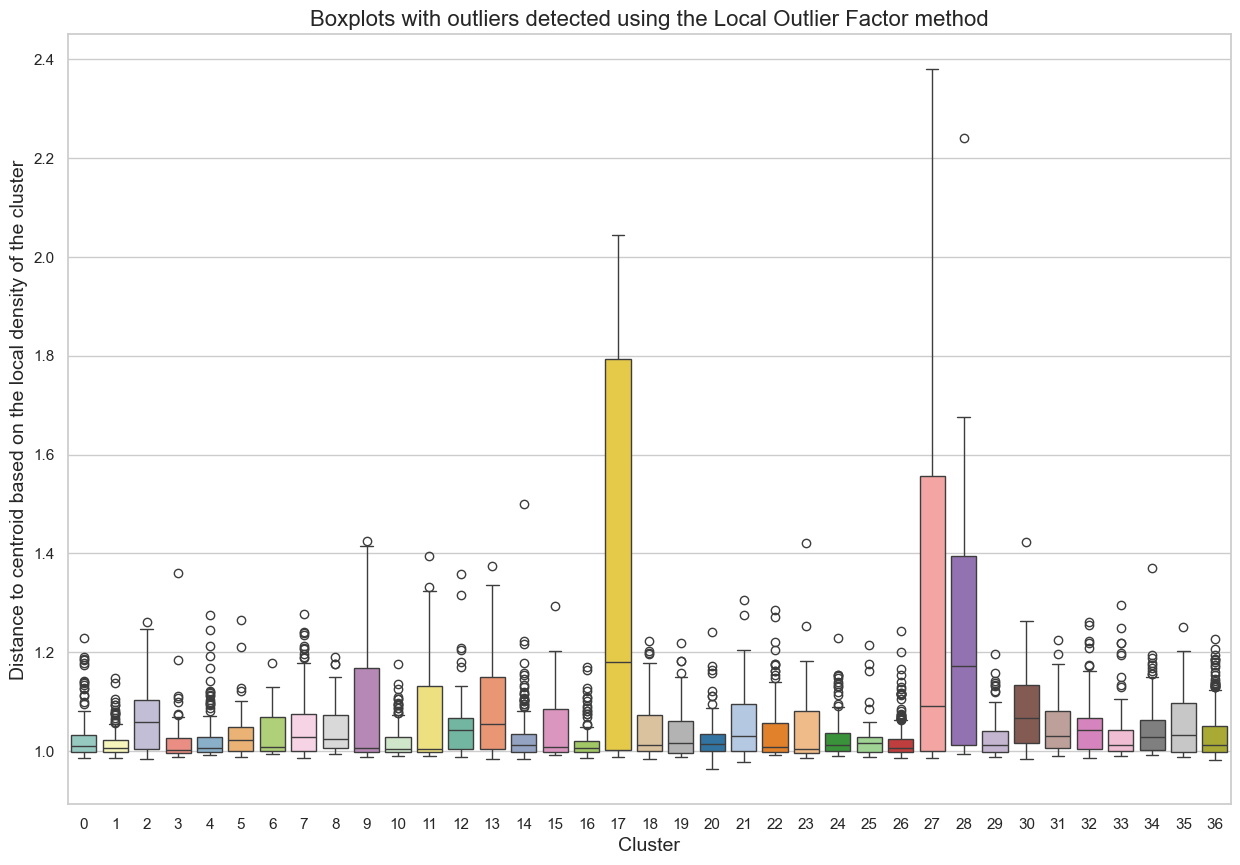

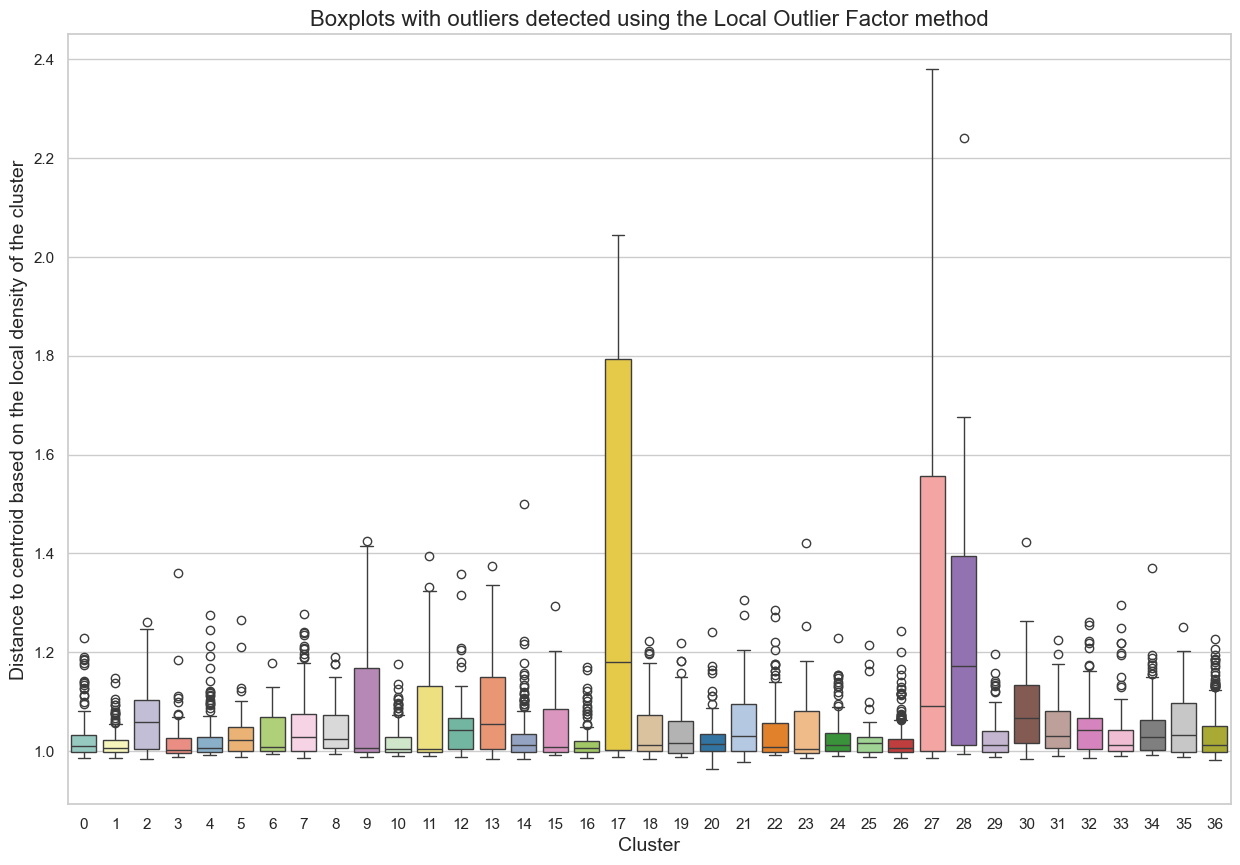

In [150]:
LOF()

Cluster Number: 14, Cluster Name: 14, Number of Outliers: 1
Cluster Number: 17, Cluster Name: 17, Number of Outliers: 30
Cluster Number: 27, Cluster Name: 27, Number of Outliers: 85
Cluster Number: 28, Cluster Name: 28, Number of Outliers: 49


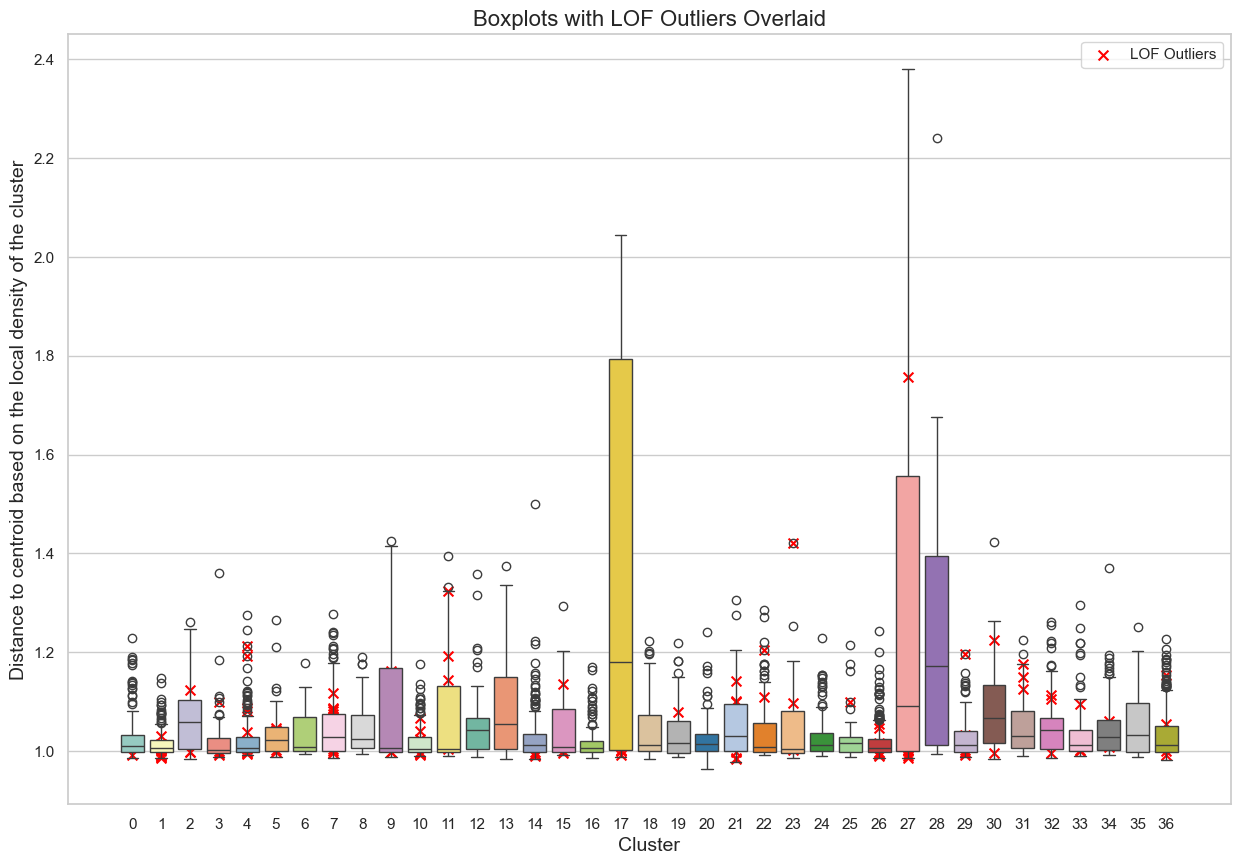

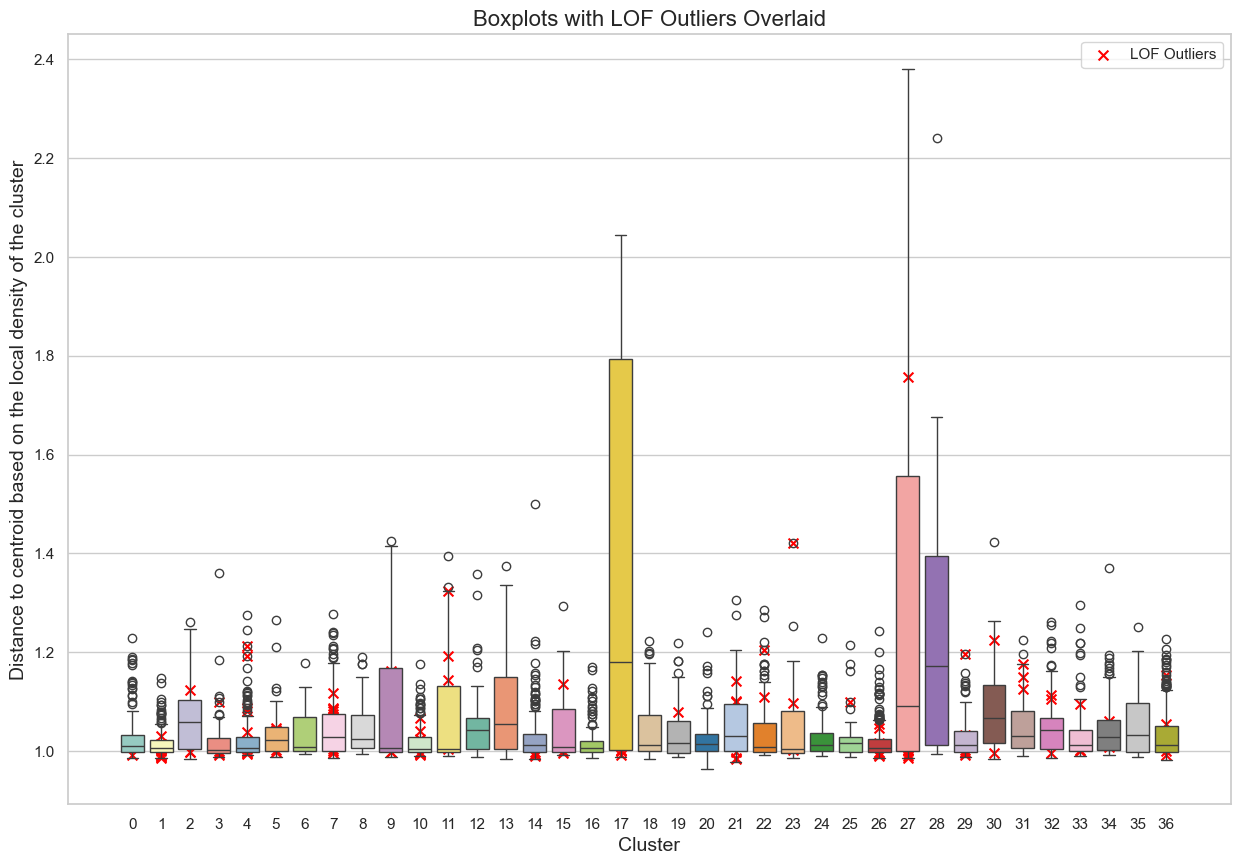

In [151]:
def LOF():
    def plot_boxplots_and_identify_outliers(cluster_data, etiqueta_numero, contamination):
        # Fit Local Outlier Factor
        tam = len(cluster_data)
        neig = abs(tam * 0.25)  # Calculate number of neighbors
        neig = int(neig)
        lof = LocalOutlierFactor(n_neighbors=neig, contamination=contamination)
        outlier_labels = lof.fit_predict(cluster_data)
        
        # Identify inliers and outliers
        is_outlier = outlier_labels == -1
        num_outliers = np.sum(is_outlier)
        
        # Create a DataFrame for plotting
        distances = lof.negative_outlier_factor_  # Get the negative outlier factor for distances
        data_to_plot = pd.DataFrame({'Distancia': -distances, 'Cluster': etiqueta_numero})
        
        return data_to_plot, num_outliers, is_outlier

    # Assume 'embeddings_df' is your DataFrame with cluster labels
    contamination = 'auto'  # Adjust contamination as needed

    # Prepare a list to gather all data and a dictionary to count outliers
    all_data = []
    outlier_counts = {}

    # Create an array to store outlier information
    all_outlier_labels = []

    # Generate boxplots and count outliers for each cluster
    for idx, label in enumerate(embeddings_df['etiqueta_numero'].unique()):
        cluster_data = np.array(embeddings_df[embeddings_df['etiqueta_numero'] == label]['content_vector_norm'].tolist())
        data_to_plot, num_outliers, is_outlier = plot_boxplots_and_identify_outliers(cluster_data, label, contamination)

        # Append data for the current cluster to the list
        all_data.append(data_to_plot)

        # Store outlier labels for the current cluster
        all_outlier_labels.append(pd.Series(is_outlier, index=embeddings_df[embeddings_df['etiqueta_numero'] == label].index))

        # Store the number of outliers
        outlier_counts[label] = num_outliers
        
        # Print the cluster index (number) and name (label)
        if num_outliers > 0:
            print(f"Cluster Number: {idx}, Cluster Name: {label}, Number of Outliers: {num_outliers}")

    # Combine all data into a single DataFrame
    combined_data = pd.concat(all_data, ignore_index=True)

    # Create a DataFrame for outlier counts and sort it
    outlier_counts_df = pd.DataFrame(list(outlier_counts.items()), columns=['Cluster', 'Num_Outliers'])
    outlier_counts_df['Cluster'] = outlier_counts_df['Cluster'].astype('category')
    outlier_counts_df = outlier_counts_df.sort_values(by='Num_Outliers', ascending=False)

    # Ensure the cluster labels are preserved
    combined_data['Cluster'] = combined_data['Cluster'].astype('category')

    # Concatenate the outlier labels into a single Series
    embeddings_df['is_outlier'] = pd.concat(all_outlier_labels)

    # Optionally convert is_outlier to categorical
    embeddings_df['is_outlier'] = embeddings_df['is_outlier'].map({True: '1', False: '0'}).astype('category')

    # Create a vertical plot with horizontal boxplots (clusters on x-axis)
    plt.figure(figsize=(15, 10))

    # Seaborn boxplot
    sns.boxplot(data=combined_data, x='Cluster', y='Distancia', 
                palette=custom_palette)  # Use lighter pastel colors

    # Overlay LOF outliers
    for cluster in combined_data['Cluster'].unique():
        cluster_data = combined_data[combined_data['Cluster'] == cluster]
        outliers = cluster_data[embeddings_df.loc[cluster_data.index, 'is_outlier'] == '1']
        plt.scatter(outliers['Cluster'], outliers['Distancia'], 
                    color='red', s=50, label='LOF Outliers' if cluster == combined_data['Cluster'].unique()[0] else "", 
                    marker='x')

    # Add titles and labels
    plt.title('Boxplots with LOF Outliers Overlaid', fontsize=16)
    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel('Distance to centroid based on the local density of the cluster', fontsize=14)
    plt.legend()

    return plt.gcf()

LOF()

The discrepancy between the number of outliers computed by the code and those observed in the boxplot arises from the different methods used to identify outliers. The code uses the Local Outlier Factor (LOF), which detects outliers based on the density and local deviation of a data point relative to its neighbors. In contrast, the boxplot represents the distribution of distances (derived from LOF) and flags any points outside the whiskers (typically set to 1.5 times the interquartile range) as "outliers." These boxplot outliers are based on statistical rules, which differ from LOF’s density-based criteria.

Cluster 0: Total Points=123, LOF Outliers=3
Cluster 1: Total Points=196, LOF Outliers=2
Cluster 2: Total Points=221, LOF Outliers=7
Cluster 3: Total Points=108, LOF Outliers=3
Cluster 4: Total Points=180, LOF Outliers=5
Cluster 5: Total Points=138, LOF Outliers=1
Cluster 7: Total Points=335, LOF Outliers=11
Cluster 8: Total Points=124, LOF Outliers=3
Cluster 9: Total Points=90, LOF Outliers=3
Cluster 10: Total Points=190, LOF Outliers=7
Cluster 11: Total Points=113, LOF Outliers=3
Cluster 12: Total Points=104, LOF Outliers=3
Cluster 13: Total Points=85, LOF Outliers=2
Cluster 14: Total Points=153, LOF Outliers=7
Cluster 15: Total Points=151, LOF Outliers=4
Cluster 16: Total Points=166, LOF Outliers=2
Cluster 18: Total Points=115, LOF Outliers=3
Cluster 19: Total Points=202, LOF Outliers=4
Cluster 21: Total Points=143, LOF Outliers=2
Cluster 22: Total Points=131, LOF Outliers=4
Cluster 24: Total Points=123, LOF Outliers=4
Cluster 26: Total Points=302, LOF Outliers=6
Cluster 27: Total Po

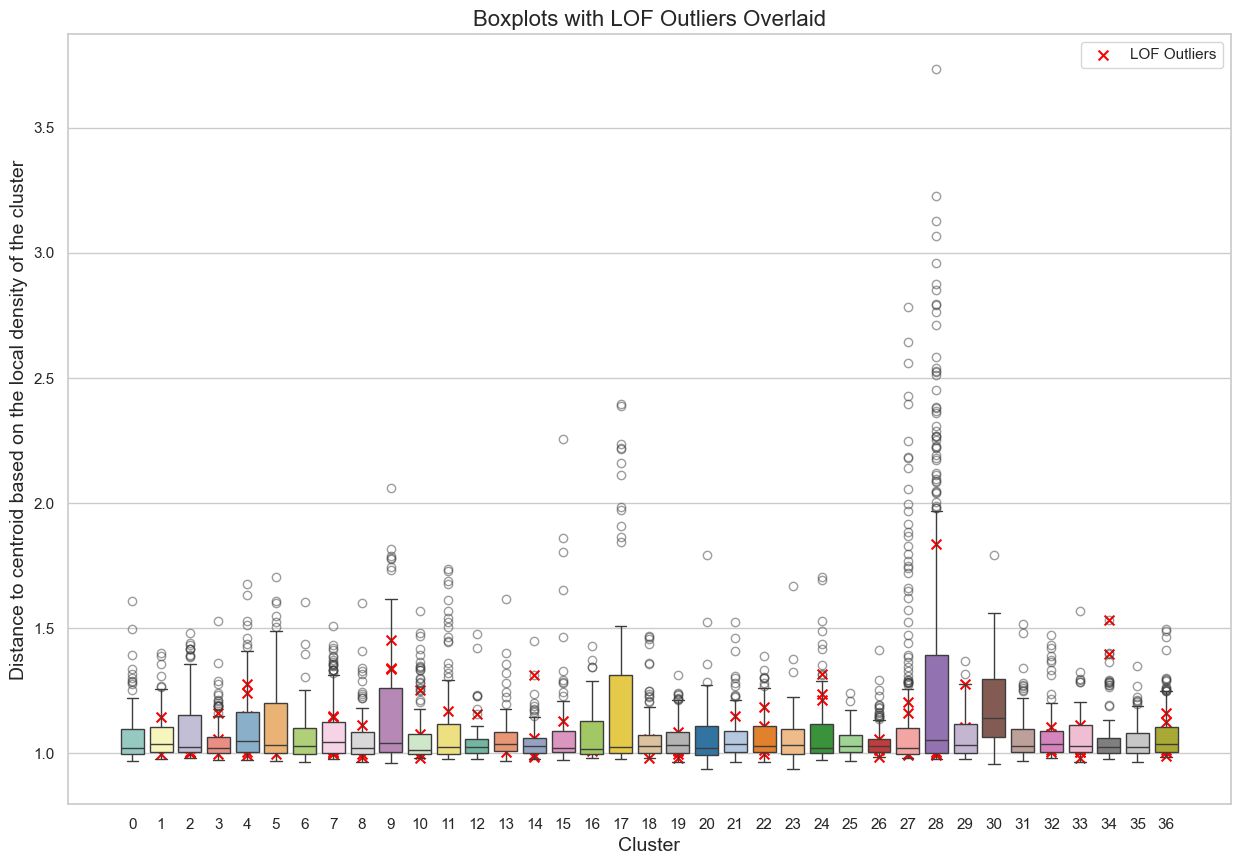

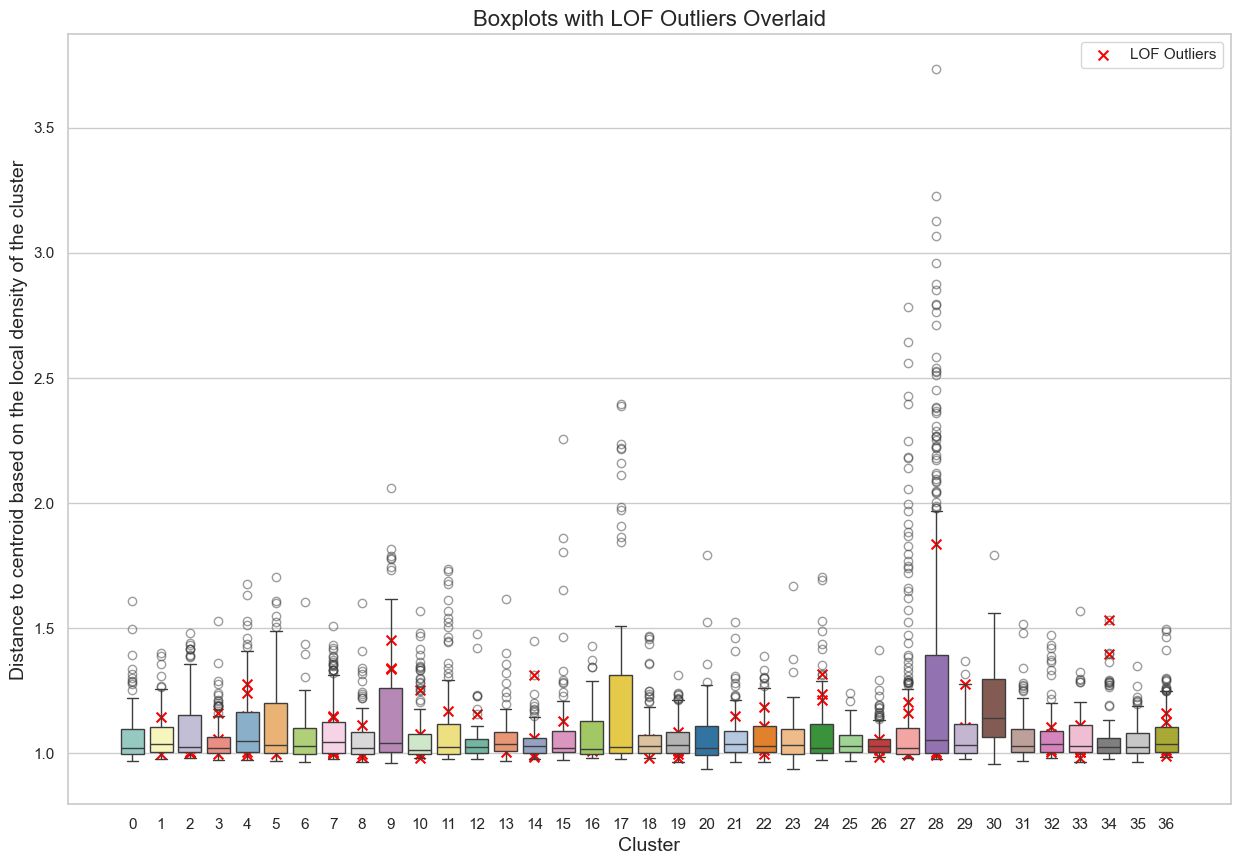

In [171]:
def LOF():
    def plot_boxplots_and_identify_outliers(cluster_data, etiqueta_numero, contamination):
        # Fit Local Outlier Factor
        tam = len(cluster_data)
        neig = abs(tam * 0.05)  # Calculate number of neighbors
        neig = int(neig)
        lof = LocalOutlierFactor(n_neighbors=neig, contamination=contamination)
        outlier_labels = lof.fit_predict(cluster_data)
        
        # Identify inliers and outliers
        is_outlier = outlier_labels == -1
        num_outliers = np.sum(is_outlier)
        
        # Create a DataFrame for plotting
        distances = lof.negative_outlier_factor_  # Get the negative outlier factor for distances
        data_to_plot = pd.DataFrame({'Distancia': -distances, 'Cluster': etiqueta_numero})
        
        return data_to_plot, num_outliers, is_outlier


    contamination = 0.02  # Adjust contamination as needed

    # Prepare a list to gather all data and a dictionary to count outliers
    all_data = []
    outlier_counts = {}

    # Create an array to store outlier information
    all_outlier_labels = []

    # Generate boxplots and count outliers for each cluster
    for idx, label in enumerate(embeddings_df['etiqueta_numero'].unique()):
        cluster_data = np.array(embeddings_df[embeddings_df['etiqueta_numero'] == label]['content_vector_norm'].tolist())
        data_to_plot, num_outliers, is_outlier = plot_boxplots_and_identify_outliers(cluster_data, label, contamination)

        # Append data for the current cluster to the list
        all_data.append(data_to_plot)

        # Store outlier labels for the current cluster
        all_outlier_labels.append(pd.Series(is_outlier, index=embeddings_df[embeddings_df['etiqueta_numero'] == label].index))

        # Store the number of outliers
        outlier_counts[label] = num_outliers
        


    # Combine all data into a single DataFrame
    combined_data = pd.concat(all_data, ignore_index=True)

    # Create a DataFrame for outlier counts and sort it
    outlier_counts_df = pd.DataFrame(list(outlier_counts.items()), columns=['Cluster', 'Num_Outliers'])
    outlier_counts_df['Cluster'] = outlier_counts_df['Cluster'].astype('category')
    outlier_counts_df = outlier_counts_df.sort_values(by='Num_Outliers', ascending=False)

    # Ensure the cluster labels are preserved
    combined_data['Cluster'] = combined_data['Cluster'].astype('category')

    # Concatenate the outlier labels into a single Series
    embeddings_df['is_outlier'] = pd.concat(all_outlier_labels)

    # Optionally convert is_outlier to categorical
    embeddings_df['is_outlier'] = embeddings_df['is_outlier'].map({True: '1', False: '0'}).astype('category')

    # Customize flier properties for boxplot outliers
    flierprops = dict(marker='o', color='grey', alpha=0.5)

    # Create a vertical plot with horizontal boxplots (clusters on x-axis)
    plt.figure(figsize=(15, 10))

    # Seaborn boxplot with customized flierprops
    sns.boxplot(data=combined_data, x='Cluster', y='Distancia', 
                palette=custom_palette, flierprops=flierprops)

    # Overlay LOF outliers
    count=0
    for cluster in combined_data['Cluster'].unique():
        cluster_data = combined_data[combined_data['Cluster'] == cluster]
        outliers = cluster_data[embeddings_df.loc[cluster_data.index, 'is_outlier'] == '1']
        if len(outliers)>0:
            print(f"Cluster {cluster}: Total Points={len(cluster_data)}, LOF Outliers={len(outliers)}")
            count+=len(outliers)
        plt.scatter(outliers['Cluster'], outliers['Distancia'], 
                    color='red', s=50, label='LOF Outliers' if cluster == combined_data['Cluster'].unique()[0] else "", 
                    marker='x')
    print(count)
    # Add titles and labels
    plt.title('Boxplots with LOF Outliers Overlaid', fontsize=16)
    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel('Distance to centroid based on the local density of the cluster', fontsize=14)
    plt.legend()

    return plt.gcf()

LOF()

Cluster 0: Total Points=123, LOF Outliers=3
Cluster 1: Total Points=196, LOF Outliers=2
Cluster 2: Total Points=221, LOF Outliers=7
Cluster 3: Total Points=108, LOF Outliers=3
Cluster 4: Total Points=180, LOF Outliers=5
Cluster 5: Total Points=138, LOF Outliers=1
Cluster 7: Total Points=335, LOF Outliers=11
Cluster 8: Total Points=124, LOF Outliers=3
Cluster 9: Total Points=90, LOF Outliers=3
Cluster 10: Total Points=190, LOF Outliers=7
Cluster 11: Total Points=113, LOF Outliers=3
Cluster 12: Total Points=104, LOF Outliers=3
Cluster 13: Total Points=85, LOF Outliers=2
Cluster 14: Total Points=153, LOF Outliers=7
Cluster 15: Total Points=151, LOF Outliers=4
Cluster 16: Total Points=166, LOF Outliers=2
Cluster 18: Total Points=115, LOF Outliers=3
Cluster 19: Total Points=202, LOF Outliers=4
Cluster 21: Total Points=143, LOF Outliers=2
Cluster 22: Total Points=131, LOF Outliers=4
Cluster 24: Total Points=123, LOF Outliers=4
Cluster 26: Total Points=302, LOF Outliers=6
Cluster 27: Total Po

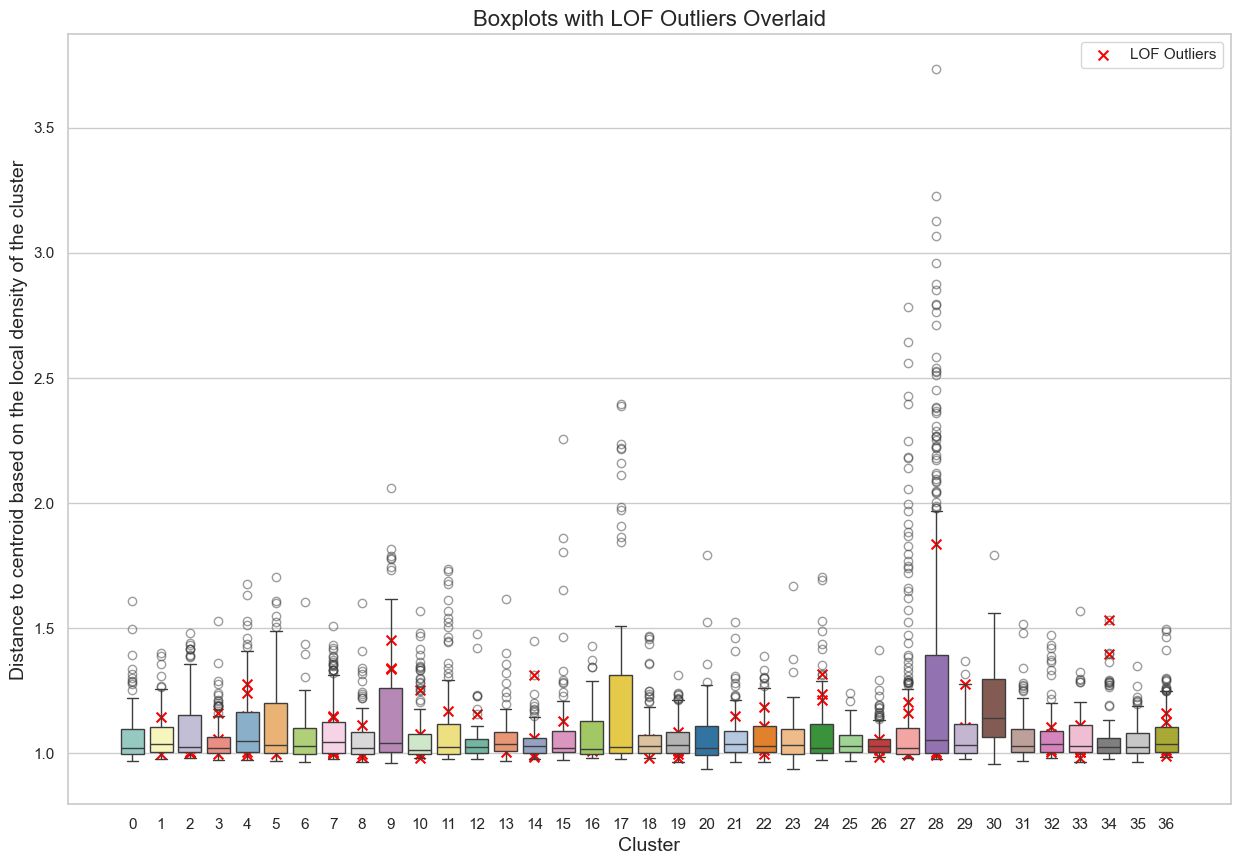

In [168]:
warnings.filterwarnings("ignore")
fig=LOF()
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)
print(interpretation)

In [ ]:
warnings.filterwarnings("ignore")
fig=LOF()
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)
print(interpretation)

# Clusters to Graph Analysis

### each cluster is a node and the edges are given by the presence of chunks with same document_id

In [87]:
embeddings_df.head(0)

,original_path,id,content,content_type,category,content_vector,document_id,chunk_id,page_number,event_url,document_name,title,description,content_vector_norm,etiqueta_asignada,centroide,etiqueta_numero


In [23]:
G = nx.Graph()

# Find unique clusters for nodes
clusters = embeddings_df['etiqueta_numero'].unique()

# Add nodes to the graph
G.add_nodes_from(clusters)

# Create edges with weights based on shared document IDs
doc_group = embeddings_df.groupby('document_id')

In [25]:
edge_weights = {}

# Iterate through each document_id group
for doc_id, group in doc_group:
    clusters_present = group['etiqueta_numero'].unique()
    #print(doc_id, group['etiqueta_numero'].unique())
    if len(clusters_present) > 1:
        #print(f"Document {doc_id} has clusters: {clusters_present}")
        for i in range(len(clusters_present)):
            for j in range(i+1, len(clusters_present)):
                edge = tuple(sorted((clusters_present[i], clusters_present[j])))
                edge_weights[edge] = edge_weights.get(edge, 0) + 1

print(f"Edge weights: {edge_weights}")
# Add edges to the graph
for edge, weight in edge_weights.items():
    G.add_edge(edge[0], edge[1], weight=weight)
print(f"Number of edges in the graph: {G.number_of_edges()}")
print(f"Number of nodes in the graph: {G.number_of_nodes()}")

Edge weights: {(7, 13): 1, (7, 8): 5, (1, 34): 3, (4, 34): 4, (8, 34): 2, (1, 4): 9, (1, 8): 3, (4, 8): 1, (1, 16): 7, (1, 7): 11, (4, 16): 5, (7, 16): 5, (4, 7): 7, (7, 34): 3, (17, 25): 13, (15, 24): 1, (17, 24): 1, (10, 22): 2, (10, 16): 5, (16, 22): 3, (4, 17): 1, (15, 22): 4, (1, 10): 1, (4, 24): 2, (1, 11): 3, (1, 22): 2, (11, 22): 1, (10, 24): 1, (1, 2): 5, (11, 16): 1, (2, 11): 2, (2, 16): 6, (2, 22): 1, (2, 7): 4, (2, 4): 1, (7, 22): 1, (4, 22): 1, (1, 24): 3, (24, 25): 1, (27, 28): 1, (26, 27): 1, (2, 6): 1, (2, 12): 1, (9, 10): 2, (17, 18): 3, (17, 19): 1, (18, 19): 5, (4, 5): 5, (1, 5): 2, (9, 32): 1, (1, 32): 1, (2, 32): 1, (1, 9): 1, (2, 9): 4, (2, 8): 1, (7, 33): 2, (5, 7): 2, (5, 33): 2, (2, 3): 1, (0, 6): 2, (0, 1): 2, (1, 6): 3, (0, 2): 1, (3, 8): 1, (7, 10): 1, (9, 11): 2, (8, 33): 1, (6, 7): 1, (11, 29): 1, (16, 29): 1, (6, 29): 1, (29, 33): 1, (1, 13): 1, (1, 17): 1, (1, 3): 1, (3, 21): 1, (0, 7): 1, (0, 4): 2, (4, 19): 2, (10, 11): 1, (4, 9): 1, (5, 9): 2, (6, 16)

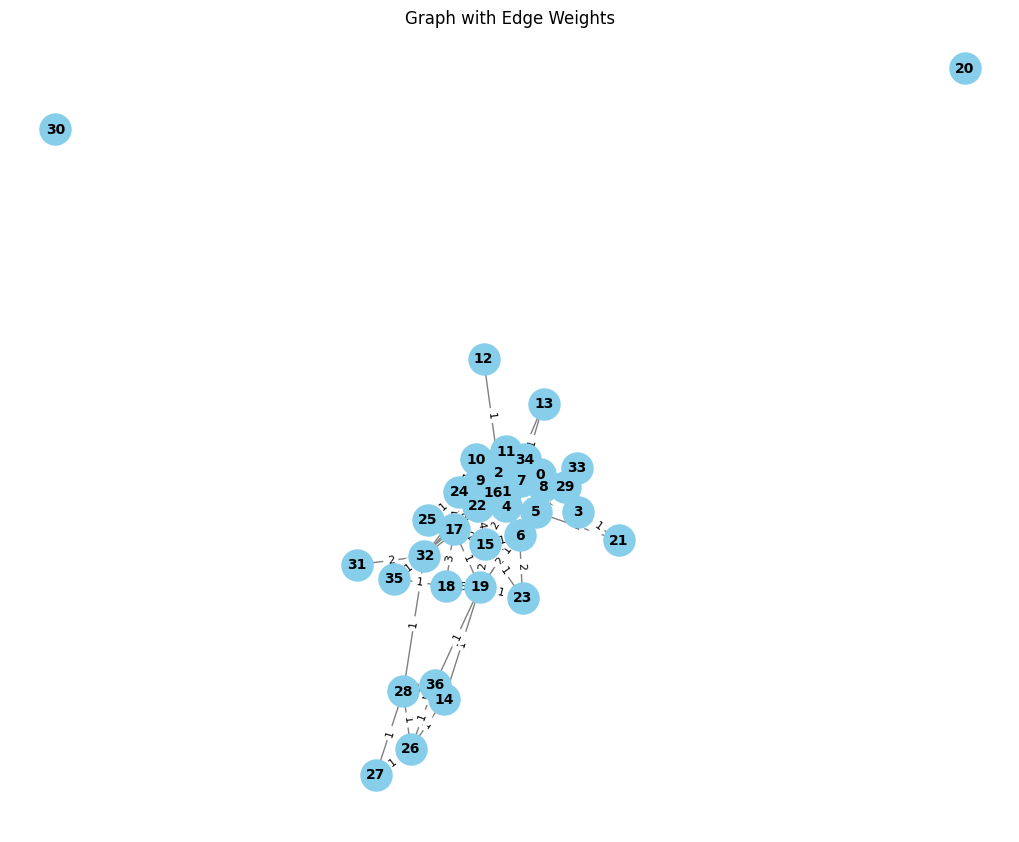

In [28]:
plt.figure(figsize=(10, 8))

# Draw the graph
pos = nx.spring_layout(G)  # Layout for positioning nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, font_size=10, font_weight='bold', edge_color='gray')

# Draw edge labels (weights)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# Display the plot
plt.title("Graph with Edge Weights")
plt.show()

Community 1: frozenset({0, 1, 2, 34, 4, 7, 8, 12, 13, 16})
Community 2: frozenset({35, 6, 15, 17, 18, 19, 22, 23, 24, 25})
Community 3: frozenset({33, 3, 5, 9, 10, 11, 21, 29})
Community 4: frozenset({32, 36, 26, 27, 28, 14, 31})
Community 5: frozenset({20})
Community 6: frozenset({30})
Modularity Score (with edge weights): 0.29380091461915453


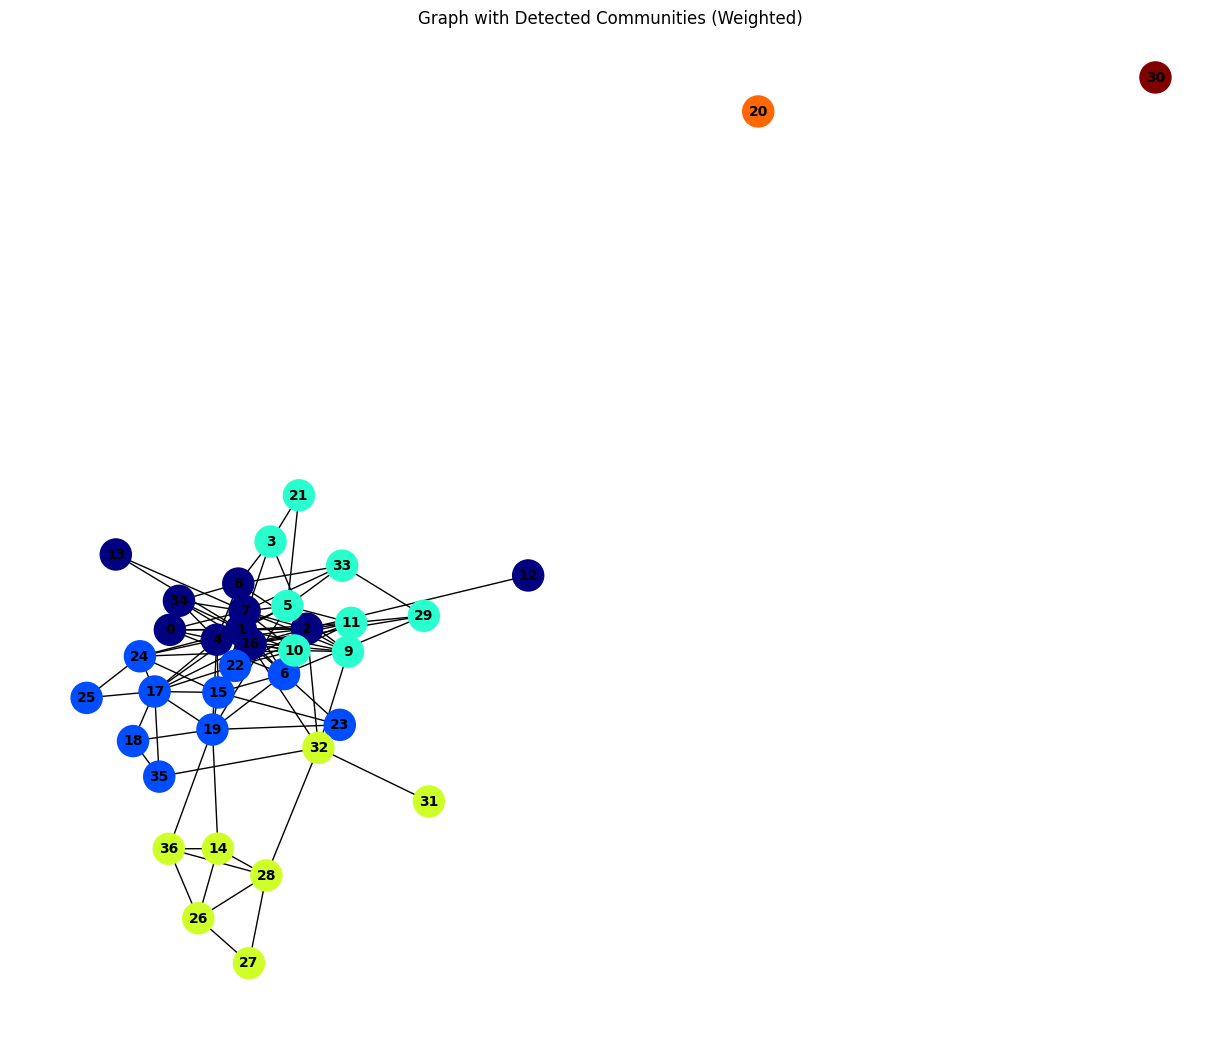

In [115]:
communities = community.greedy_modularity_communities(G, weight='weight')

# Print the detected communities
for idx, community_set in enumerate(communities):
    print(f"Community {idx+1}: {community_set}")

# Compute modularity for the detected communities, considering edge weights
modularity_score = community.modularity(G, communities, weight='weight')
print(f"Modularity Score (with edge weights): {modularity_score}")

# Now visualize the graph with the communities in different colors
# Create a color map based on community groups
community_colors = []
for node in G.nodes():
    for idx, community_set in enumerate(communities):
        if node in community_set:
            community_colors.append(idx)
            break

# Set the figure size
plt.figure(figsize=(12, 10))

# Draw the graph with nodes colored by their community
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color=community_colors, with_labels=True, cmap=plt.cm.jet, node_size=500, font_size=10, font_weight='bold')

plt.title("Graph with Detected Communities (Weighted)")
plt.show()

### Modularity Score Interpretation

- **Modularity Score: 0.2938**:  
  This indicates a **moderate community structure** in your graph. The edge weights have been taken into account, leading to a more refined partitioning of the graph than an unweighted analysis would provide.

#### Key Points:
- **Range of Modularity**: The modularity score ranges from -1 to 1:
  - A score close to **1** indicates strong community structure.
  - A score close to **0** suggests weak or no significant community structure.
  - A negative score implies worse-than-random community division.
  
- **What This Score Means**:
  - **0.2938** suggests moderate structure: The communities are somewhat distinct but not highly separated, with some overlap or weak connections between them.
  - The inclusion of **edge weights** has helped improve the community detection compared to an unweighted modularity score (0.1848). Stronger edges (i.e., connections with higher weights) played a role in better community assignments.

#### Strength of the Communities:
- This score indicates that the network has a **moderate community structure**. While the communities are relatively well-defined, there is still a significant amount of random mixing or weak ties between them.

#### Next Steps:
- **Optimization**: If the goal is to identify highly distinct communities, you may consider exploring other community detection algorithms (e.g., the Louvain method) or adjusting parameters to try and achieve a higher modularity score.
- **Moderate to Good**: A modularity score above **0.3** generally suggests that the communities detected have some meaningful structure.

### Context:
- In **real-world networks** (e.g., social networks, collaboration networks, biological networks), a modularity score above **0.3** typically indicates **moderately well-defined communities**.
- A score above **0.4 to 0.5** would be considered very good, with highly distinct and meaningful community separations.

In summary, the **modularity score of 0.2938** suggests a **moderate but meaningful community structure** in your weighted network. There's room for improvement, but the current community detection reflects some degree of meaningful partitioning.


C:\Users\55641856\AppData\Local\Temp\ipykernel_31416\2101653201.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, cumulative_sum[j] - chunk_count_pivot.loc[cluster, color] / 2,


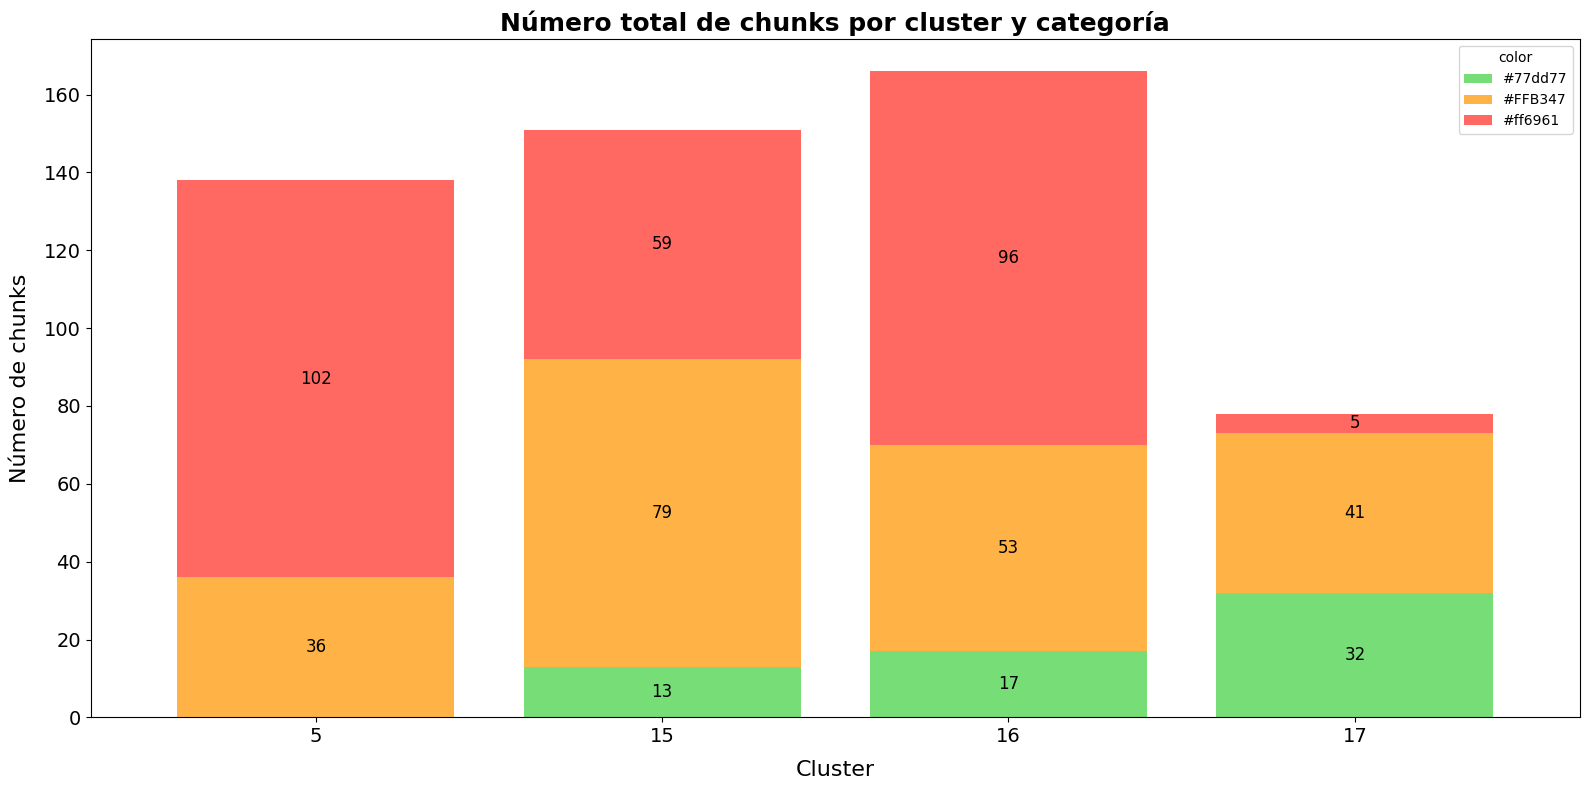

In [42]:
def plot_chunk_stacked():
    # Filter the data for specific 'etiqueta_numero' values (5, 15, 16, 17)
    target_etiqueta = [5, 15, 16, 17]
    filtered_embeddings_df = embeddings_df[embeddings_df['etiqueta_numero'].isin(target_etiqueta)]

    # Group by 'etiqueta_numero', 'color', and 'chunk_id', then count the chunks
    chunk_count_per_document_color = filtered_embeddings_df.groupby(['etiqueta_numero', 'color', 'chunk_id']).size().reset_index(name='chunk_count')
    
    # Pivot the data to prepare it for plotting
    chunk_count_pivot = chunk_count_per_document_color.pivot_table(index='etiqueta_numero', columns='color', values='chunk_count', aggfunc='sum', fill_value=0)

    # Create the stacked bar plot using the 'color' column from the dataframe
    ax = chunk_count_pivot.plot(kind='bar', stacked=True, figsize=(16, 8), width=0.8, color=chunk_count_pivot.columns, edgecolor='none')

    # Annotate the bars with the chunk count values
    for i, cluster in enumerate(chunk_count_pivot.index):
        cumulative_sum = chunk_count_pivot.loc[cluster].cumsum()
        for j, color in enumerate(chunk_count_pivot.columns):
            if chunk_count_pivot.loc[cluster, color] > 0:
                plt.text(i, cumulative_sum[j] - chunk_count_pivot.loc[cluster, color] / 2, 
                         f'{chunk_count_pivot.loc[cluster, color]}', ha='center', va='center', fontsize=12, color='black')

    # Set plot titles and labels
    plt.title('Número total de chunks por cluster y categoría', fontsize=18, fontweight='bold')
    plt.xlabel('Cluster', fontsize=16, labelpad=10)
    plt.ylabel('Número de chunks', fontsize=16, labelpad=10)

    # Set the ticks
    plt.xticks(rotation=0, fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()

    # Add the legend for the categories, using color and category mapping
    # Use the color from chunk_count_pivot.columns as the legend handles and the category names as labels
    handles = [plt.Line2D([0], [0], color=color, lw=4) for color in chunk_count_pivot.columns]
    labels = [category for category in chunk_count_pivot.columns]  # Category names are the colors
    #ax.legend(handles, labels, title="Categorías", title_fontsize=14, fontsize=12, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

    # Show the plot
    plt.show()

    return ax.figure

# Call the function and capture the figure
fig = plot_chunk_stacked()

# Assuming you have a method to convert the figure to an image
fig_array = fig_to_image(fig)

# # Send the image to OpenAI for interpretation (assuming openai_client is set up)
# interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)
# print(interpretation)


# prueba Markitdown

In [2]:
# type: ignore
import base64
import binascii
import copy
import html
import json
import mimetypes
import os
import re
import shutil
import subprocess
import sys
import tempfile
import traceback
import zipfile
from xml.dom import minidom
from typing import Any, Dict, List, Optional, Union
from pathlib import Path
from urllib.parse import parse_qs, quote, unquote, urlparse, urlunparse
from warnings import warn, resetwarnings, catch_warnings

import mammoth
import markdownify
import olefile
import pandas as pd
import pdfminer
import pdfminer.high_level
import pptx

# File-format detection
import puremagic
import requests
from bs4 import BeautifulSoup
from charset_normalizer import from_path

# Optional Transcription support
IS_AUDIO_TRANSCRIPTION_CAPABLE = False
try:
    # Using warnings' catch_warnings to catch
    # pydub's warning of ffmpeg or avconv missing
    with catch_warnings(record=True) as w:
        import pydub

        if w:
            raise ModuleNotFoundError
    import speech_recognition as sr

    IS_AUDIO_TRANSCRIPTION_CAPABLE = True
except ModuleNotFoundError:
    pass
finally:
    resetwarnings()

# Optional YouTube transcription support
try:
    from youtube_transcript_api import YouTubeTranscriptApi

    IS_YOUTUBE_TRANSCRIPT_CAPABLE = True
except ModuleNotFoundError:
    pass


class _CustomMarkdownify(markdownify.MarkdownConverter):
    """
    A custom version of markdownify's MarkdownConverter. Changes include:

    - Altering the default heading style to use '#', '##', etc.
    - Removing javascript hyperlinks.
    - Truncating images with large data:uri sources.
    - Ensuring URIs are properly escaped, and do not conflict with Markdown syntax
    """

    def __init__(self, **options: Any):
        options["heading_style"] = options.get("heading_style", markdownify.ATX)
        # Explicitly cast options to the expected type if necessary
        super().__init__(**options)

    def convert_hn(self, n: int, el: Any, text: str, convert_as_inline: bool) -> str:
        """Same as usual, but be sure to start with a new line"""
        if not convert_as_inline:
            if not re.search(r"^\n", text):
                return "\n" + super().convert_hn(n, el, text, convert_as_inline)  # type: ignore

        return super().convert_hn(n, el, text, convert_as_inline)  # type: ignore

    def convert_a(self, el: Any, text: str, convert_as_inline: bool):
        """Same as usual converter, but removes Javascript links and escapes URIs."""
        prefix, suffix, text = markdownify.chomp(text)  # type: ignore
        if not text:
            return ""
        href = el.get("href")
        title = el.get("title")

        # Escape URIs and skip non-http or file schemes
        if href:
            try:
                parsed_url = urlparse(href)  # type: ignore
                if parsed_url.scheme and parsed_url.scheme.lower() not in ["http", "https", "file"]:  # type: ignore
                    return "%s%s%s" % (prefix, text, suffix)
                href = urlunparse(parsed_url._replace(path=quote(unquote(parsed_url.path))))  # type: ignore
            except ValueError:  # It's not clear if this ever gets thrown
                return "%s%s%s" % (prefix, text, suffix)

        # For the replacement see #29: text nodes underscores are escaped
        if (
            self.options["autolinks"]
            and text.replace(r"\_", "_") == href
            and not title
            and not self.options["default_title"]
        ):
            # Shortcut syntax
            return "<%s>" % href
        if self.options["default_title"] and not title:
            title = href
        title_part = ' "%s"' % title.replace('"', r"\"") if title else ""
        return (
            "%s[%s](%s%s)%s" % (prefix, text, href, title_part, suffix)
            if href
            else text
        )

    def convert_img(self, el: Any, text: str, convert_as_inline: bool) -> str:
        """Same as usual converter, but removes data URIs"""

        alt = el.attrs.get("alt", None) or ""
        src = el.attrs.get("src", None) or ""
        title = el.attrs.get("title", None) or ""
        title_part = ' "%s"' % title.replace('"', r"\"") if title else ""
        if (
            convert_as_inline
            and el.parent.name not in self.options["keep_inline_images_in"]
        ):
            return alt

        # Remove dataURIs
        if src.startswith("data:"):
            src = src.split(",")[0] + "..."

        return "![%s](%s%s)" % (alt, src, title_part)

    def convert_soup(self, soup: Any) -> str:
        return super().convert_soup(soup)  # type: ignore


class DocumentConverterResult:
    """The result of converting a document to text."""

    def __init__(self, title: Union[str, None] = None, text_content: str = ""):
        self.title: Union[str, None] = title
        self.text_content: str = text_content


class DocumentConverter:
    """Abstract superclass of all DocumentConverters."""

    def convert(
        self, local_path: str, **kwargs: Any
    ) -> Union[None, DocumentConverterResult]:
        raise NotImplementedError()


class PlainTextConverter(DocumentConverter):
    """Anything with content type text/plain"""

    def convert(
        self, local_path: str, **kwargs: Any
    ) -> Union[None, DocumentConverterResult]:
        # Guess the content type from any file extension that might be around
        content_type, _ = mimetypes.guess_type(
            "__placeholder" + kwargs.get("file_extension", "")
        )

        # Only accept text files
        if content_type is None:
            return None
        elif all(
            not content_type.lower().startswith(type_prefix)
            for type_prefix in ["text/", "application/json"]
        ):
            return None

        text_content = str(from_path(local_path).best())
        return DocumentConverterResult(
            title=None,
            text_content=text_content,
        )


class HtmlConverter(DocumentConverter):
    """Anything with content type text/html"""

    def convert(
        self, local_path: str, **kwargs: Any
    ) -> Union[None, DocumentConverterResult]:
        # Bail if not html
        extension = kwargs.get("file_extension", "")
        if extension.lower() not in [".html", ".htm"]:
            return None

        result = None
        with open(local_path, "rt", encoding="utf-8") as fh:
            result = self._convert(fh.read())

        return result

    def _convert(self, html_content: str) -> Union[None, DocumentConverterResult]:
        """Helper function that converts and HTML string."""

        # Parse the string
        soup = BeautifulSoup(html_content, "html.parser")

        # Remove javascript and style blocks
        for script in soup(["script", "style"]):
            script.extract()

        # Print only the main content
        body_elm = soup.find("body")
        webpage_text = ""
        if body_elm:
            webpage_text = _CustomMarkdownify().convert_soup(body_elm)
        else:
            webpage_text = _CustomMarkdownify().convert_soup(soup)

        assert isinstance(webpage_text, str)

        return DocumentConverterResult(
            title=None if soup.title is None else soup.title.string,
            text_content=webpage_text,
        )


class RSSConverter(DocumentConverter):
    """Convert RSS / Atom type to markdown"""

    def convert(
        self, local_path: str, **kwargs
    ) -> Union[None, DocumentConverterResult]:
        # Bail if not RSS type
        extension = kwargs.get("file_extension", "")
        if extension.lower() not in [".xml", ".rss", ".atom"]:
            return None
        try:
            doc = minidom.parse(local_path)
        except BaseException as _:
            return None
        result = None
        if doc.getElementsByTagName("rss"):
            # A RSS feed must have a root element of <rss>
            result = self._parse_rss_type(doc)
        elif doc.getElementsByTagName("feed"):
            root = doc.getElementsByTagName("feed")[0]
            if root.getElementsByTagName("entry"):
                # An Atom feed must have a root element of <feed> and at least one <entry>
                result = self._parse_atom_type(doc)
            else:
                return None
        else:
            # not rss or atom
            return None

        return result

    def _parse_atom_type(
        self, doc: minidom.Document
    ) -> Union[None, DocumentConverterResult]:
        """Parse the type of an Atom feed.

        Returns None if the feed type is not recognized or something goes wrong.
        """
        try:
            root = doc.getElementsByTagName("feed")[0]
            title = self._get_data_by_tag_name(root, "title")
            subtitle = self._get_data_by_tag_name(root, "subtitle")
            entries = root.getElementsByTagName("entry")
            md_text = f"# {title}\n"
            if subtitle:
                md_text += f"{subtitle}\n"
            for entry in entries:
                entry_title = self._get_data_by_tag_name(entry, "title")
                entry_summary = self._get_data_by_tag_name(entry, "summary")
                entry_updated = self._get_data_by_tag_name(entry, "updated")
                entry_content = self._get_data_by_tag_name(entry, "content")

                if entry_title:
                    md_text += f"\n## {entry_title}\n"
                if entry_updated:
                    md_text += f"Updated on: {entry_updated}\n"
                if entry_summary:
                    md_text += self._parse_content(entry_summary)
                if entry_content:
                    md_text += self._parse_content(entry_content)

            return DocumentConverterResult(
                title=title,
                text_content=md_text,
            )
        except BaseException as _:
            return None

    def _parse_rss_type(
        self, doc: minidom.Document
    ) -> Union[None, DocumentConverterResult]:
        """Parse the type of an RSS feed.

        Returns None if the feed type is not recognized or something goes wrong.
        """
        try:
            root = doc.getElementsByTagName("rss")[0]
            channel = root.getElementsByTagName("channel")
            if not channel:
                return None
            channel = channel[0]
            channel_title = self._get_data_by_tag_name(channel, "title")
            channel_description = self._get_data_by_tag_name(channel, "description")
            items = channel.getElementsByTagName("item")
            if channel_title:
                md_text = f"# {channel_title}\n"
            if channel_description:
                md_text += f"{channel_description}\n"
            if not items:
                items = []
            for item in items:
                title = self._get_data_by_tag_name(item, "title")
                description = self._get_data_by_tag_name(item, "description")
                pubDate = self._get_data_by_tag_name(item, "pubDate")
                content = self._get_data_by_tag_name(item, "content:encoded")

                if title:
                    md_text += f"\n## {title}\n"
                if pubDate:
                    md_text += f"Published on: {pubDate}\n"
                if description:
                    md_text += self._parse_content(description)
                if content:
                    md_text += self._parse_content(content)

            return DocumentConverterResult(
                title=channel_title,
                text_content=md_text,
            )
        except BaseException as _:
            print(traceback.format_exc())
            return None

    def _parse_content(self, content: str) -> str:
        """Parse the content of an RSS feed item"""
        try:
            # using bs4 because many RSS feeds have HTML-styled content
            soup = BeautifulSoup(content, "html.parser")
            return _CustomMarkdownify().convert_soup(soup)
        except BaseException as _:
            return content

    def _get_data_by_tag_name(
        self, element: minidom.Element, tag_name: str
    ) -> Union[str, None]:
        """Get data from first child element with the given tag name.
        Returns None when no such element is found.
        """
        nodes = element.getElementsByTagName(tag_name)
        if not nodes:
            return None
        fc = nodes[0].firstChild
        if fc:
            return fc.data
        return None


class WikipediaConverter(DocumentConverter):
    """Handle Wikipedia pages separately, focusing only on the main document content."""

    def convert(
        self, local_path: str, **kwargs: Any
    ) -> Union[None, DocumentConverterResult]:
        # Bail if not Wikipedia
        extension = kwargs.get("file_extension", "")
        if extension.lower() not in [".html", ".htm"]:
            return None
        url = kwargs.get("url", "")
        if not re.search(r"^https?:\/\/[a-zA-Z]{2,3}\.wikipedia.org\/", url):
            return None

        # Parse the file
        soup = None
        with open(local_path, "rt", encoding="utf-8") as fh:
            soup = BeautifulSoup(fh.read(), "html.parser")

        # Remove javascript and style blocks
        for script in soup(["script", "style"]):
            script.extract()

        # Print only the main content
        body_elm = soup.find("div", {"id": "mw-content-text"})
        title_elm = soup.find("span", {"class": "mw-page-title-main"})

        webpage_text = ""
        main_title = None if soup.title is None else soup.title.string

        if body_elm:
            # What's the title
            if title_elm and len(title_elm) > 0:
                main_title = title_elm.string  # type: ignore
                assert isinstance(main_title, str)

            # Convert the page
            webpage_text = f"# {main_title}\n\n" + _CustomMarkdownify().convert_soup(
                body_elm
            )
        else:
            webpage_text = _CustomMarkdownify().convert_soup(soup)

        return DocumentConverterResult(
            title=main_title,
            text_content=webpage_text,
        )


class YouTubeConverter(DocumentConverter):
    """Handle YouTube specially, focusing on the video title, description, and transcript."""

    def convert(
        self, local_path: str, **kwargs: Any
    ) -> Union[None, DocumentConverterResult]:
        # Bail if not YouTube
        extension = kwargs.get("file_extension", "")
        if extension.lower() not in [".html", ".htm"]:
            return None
        url = kwargs.get("url", "")
        if not url.startswith("https://www.youtube.com/watch?"):
            return None

        # Parse the file
        soup = None
        with open(local_path, "rt", encoding="utf-8") as fh:
            soup = BeautifulSoup(fh.read(), "html.parser")

        # Read the meta tags
        assert soup.title is not None and soup.title.string is not None
        metadata: Dict[str, str] = {"title": soup.title.string}
        for meta in soup(["meta"]):
            for a in meta.attrs:
                if a in ["itemprop", "property", "name"]:
                    metadata[meta[a]] = meta.get("content", "")
                    break

        # We can also try to read the full description. This is more prone to breaking, since it reaches into the page implementation
        try:
            for script in soup(["script"]):
                content = script.text
                if "ytInitialData" in content:
                    lines = re.split(r"\r?\n", content)
                    obj_start = lines[0].find("{")
                    obj_end = lines[0].rfind("}")
                    if obj_start >= 0 and obj_end >= 0:
                        data = json.loads(lines[0][obj_start : obj_end + 1])
                        attrdesc = self._findKey(data, "attributedDescriptionBodyText")  # type: ignore
                        if attrdesc:
                            metadata["description"] = str(attrdesc["content"])
                    break
        except Exception:
            pass

        # Start preparing the page
        webpage_text = "# YouTube\n"

        title = self._get(metadata, ["title", "og:title", "name"])  # type: ignore
        assert isinstance(title, str)

        if title:
            webpage_text += f"\n## {title}\n"

        stats = ""
        views = self._get(metadata, ["interactionCount"])  # type: ignore
        if views:
            stats += f"- **Views:** {views}\n"

        keywords = self._get(metadata, ["keywords"])  # type: ignore
        if keywords:
            stats += f"- **Keywords:** {keywords}\n"

        runtime = self._get(metadata, ["duration"])  # type: ignore
        if runtime:
            stats += f"- **Runtime:** {runtime}\n"

        if len(stats) > 0:
            webpage_text += f"\n### Video Metadata\n{stats}\n"

        description = self._get(metadata, ["description", "og:description"])  # type: ignore
        if description:
            webpage_text += f"\n### Description\n{description}\n"

        if IS_YOUTUBE_TRANSCRIPT_CAPABLE:
            transcript_text = ""
            parsed_url = urlparse(url)  # type: ignore
            params = parse_qs(parsed_url.query)  # type: ignore
            if "v" in params:
                assert isinstance(params["v"][0], str)
                video_id = str(params["v"][0])
                try:
                    youtube_transcript_languages = kwargs.get(
                        "youtube_transcript_languages", ("en",)
                    )
                    # Must be a single transcript.
                    transcript = YouTubeTranscriptApi.get_transcript(video_id, languages=youtube_transcript_languages)  # type: ignore
                    transcript_text = " ".join([part["text"] for part in transcript])  # type: ignore
                    # Alternative formatting:
                    # formatter = TextFormatter()
                    # formatter.format_transcript(transcript)
                except Exception:
                    pass
            if transcript_text:
                webpage_text += f"\n### Transcript\n{transcript_text}\n"

        title = title if title else soup.title.string
        assert isinstance(title, str)

        return DocumentConverterResult(
            title=title,
            text_content=webpage_text,
        )

    def _get(
        self,
        metadata: Dict[str, str],
        keys: List[str],
        default: Union[str, None] = None,
    ) -> Union[str, None]:
        for k in keys:
            if k in metadata:
                return metadata[k]
        return default

    def _findKey(self, json: Any, key: str) -> Union[str, None]:  # TODO: Fix json type
        if isinstance(json, list):
            for elm in json:
                ret = self._findKey(elm, key)
                if ret is not None:
                    return ret
        elif isinstance(json, dict):
            for k in json:
                if k == key:
                    return json[k]
                else:
                    ret = self._findKey(json[k], key)
                    if ret is not None:
                        return ret
        return None


class IpynbConverter(DocumentConverter):
    """Converts Jupyter Notebook (.ipynb) files to Markdown."""

    def convert(
        self, local_path: str, **kwargs: Any
    ) -> Union[None, DocumentConverterResult]:
        # Bail if not ipynb
        extension = kwargs.get("file_extension", "")
        if extension.lower() != ".ipynb":
            return None

        # Parse and convert the notebook
        result = None
        with open(local_path, "rt", encoding="utf-8") as fh:
            notebook_content = json.load(fh)
            result = self._convert(notebook_content)

        return result

    def _convert(self, notebook_content: dict) -> Union[None, DocumentConverterResult]:
        """Helper function that converts notebook JSON content to Markdown."""
        try:
            md_output = []
            title = None

            for cell in notebook_content.get("cells", []):
                cell_type = cell.get("cell_type", "")
                source_lines = cell.get("source", [])

                if cell_type == "markdown":
                    md_output.append("".join(source_lines))

                    # Extract the first # heading as title if not already found
                    if title is None:
                        for line in source_lines:
                            if line.startswith("# "):
                                title = line.lstrip("# ").strip()
                                break

                elif cell_type == "code":
                    # Code cells are wrapped in Markdown code blocks
                    md_output.append(f"```python\n{''.join(source_lines)}\n```")
                elif cell_type == "raw":
                    md_output.append(f"```\n{''.join(source_lines)}\n```")

            md_text = "\n\n".join(md_output)

            # Check for title in notebook metadata
            title = notebook_content.get("metadata", {}).get("title", title)

            return DocumentConverterResult(
                title=title,
                text_content=md_text,
            )

        except Exception as e:
            raise FileConversionException(
                f"Error converting .ipynb file: {str(e)}"
            ) from e


class BingSerpConverter(DocumentConverter):
    """
    Handle Bing results pages (only the organic search results).
    NOTE: It is better to use the Bing API
    """

    def convert(self, local_path, **kwargs) -> Union[None, DocumentConverterResult]:
        # Bail if not a Bing SERP
        extension = kwargs.get("file_extension", "")
        if extension.lower() not in [".html", ".htm"]:
            return None
        url = kwargs.get("url", "")
        if not re.search(r"^https://www\.bing\.com/search\?q=", url):
            return None

        # Parse the query parameters
        parsed_params = parse_qs(urlparse(url).query)
        query = parsed_params.get("q", [""])[0]

        # Parse the file
        soup = None
        with open(local_path, "rt", encoding="utf-8") as fh:
            soup = BeautifulSoup(fh.read(), "html.parser")

        # Clean up some formatting
        for tptt in soup.find_all(class_="tptt"):
            if hasattr(tptt, "string") and tptt.string:
                tptt.string += " "
        for slug in soup.find_all(class_="algoSlug_icon"):
            slug.extract()

        # Parse the algorithmic results
        _markdownify = _CustomMarkdownify()
        results = list()
        for result in soup.find_all(class_="b_algo"):
            # Rewrite redirect urls
            for a in result.find_all("a", href=True):
                parsed_href = urlparse(a["href"])
                qs = parse_qs(parsed_href.query)

                # The destination is contained in the u parameter,
                # but appears to be base64 encoded, with some prefix
                if "u" in qs:
                    u = (
                        qs["u"][0][2:].strip() + "=="
                    )  # Python 3 doesn't care about extra padding

                    try:
                        # RFC 4648 / Base64URL" variant, which uses "-" and "_"
                        a["href"] = base64.b64decode(u, altchars="-_").decode("utf-8")
                    except UnicodeDecodeError:
                        pass
                    except binascii.Error:
                        pass

            # Convert to markdown
            md_result = _markdownify.convert_soup(result).strip()
            lines = [line.strip() for line in re.split(r"\n+", md_result)]
            results.append("\n".join([line for line in lines if len(line) > 0]))

        webpage_text = (
            f"## A Bing search for '{query}' found the following results:\n\n"
            + "\n\n".join(results)
        )

        return DocumentConverterResult(
            title=None if soup.title is None else soup.title.string,
            text_content=webpage_text,
        )


class PdfConverter(DocumentConverter):
    """
    Converts PDFs to Markdown. Most style information is ignored, so the results are essentially plain-text.
    """

    def convert(self, local_path, **kwargs) -> Union[None, DocumentConverterResult]:
        # Bail if not a PDF
        extension = kwargs.get("file_extension", "")
        if extension.lower() != ".pdf":
            return None

        return DocumentConverterResult(
            title=None,
            text_content=pdfminer.high_level.extract_text(local_path),
        )


class DocxConverter(HtmlConverter):
    """
    Converts DOCX files to Markdown. Style information (e.g.m headings) and tables are preserved where possible.
    """

    def convert(self, local_path, **kwargs) -> Union[None, DocumentConverterResult]:
        # Bail if not a DOCX
        extension = kwargs.get("file_extension", "")
        if extension.lower() != ".docx":
            return None

        result = None
        with open(local_path, "rb") as docx_file:
            style_map = kwargs.get("style_map", None)

            result = mammoth.convert_to_html(docx_file, style_map=style_map)
            html_content = result.value
            result = self._convert(html_content)

        return result


class XlsxConverter(HtmlConverter):
    """
    Converts XLSX files to Markdown, with each sheet presented as a separate Markdown table.
    """

    def convert(self, local_path, **kwargs) -> Union[None, DocumentConverterResult]:
        # Bail if not a XLSX
        extension = kwargs.get("file_extension", "")
        if extension.lower() != ".xlsx":
            return None

        sheets = pd.read_excel(local_path, sheet_name=None, engine="openpyxl")
        md_content = ""
        for s in sheets:
            md_content += f"## {s}\n"
            html_content = sheets[s].to_html(index=False)
            md_content += self._convert(html_content).text_content.strip() + "\n\n"

        return DocumentConverterResult(
            title=None,
            text_content=md_content.strip(),
        )


class XlsConverter(HtmlConverter):
    """
    Converts XLS files to Markdown, with each sheet presented as a separate Markdown table.
    """

    def convert(self, local_path, **kwargs) -> Union[None, DocumentConverterResult]:
        # Bail if not a XLS
        extension = kwargs.get("file_extension", "")
        if extension.lower() != ".xls":
            return None

        sheets = pd.read_excel(local_path, sheet_name=None, engine="xlrd")
        md_content = ""
        for s in sheets:
            md_content += f"## {s}\n"
            html_content = sheets[s].to_html(index=False)
            md_content += self._convert(html_content).text_content.strip() + "\n\n"

        return DocumentConverterResult(
            title=None,
            text_content=md_content.strip(),
        )


class PptxConverter(HtmlConverter):
    """
    Converts PPTX files to Markdown. Supports heading, tables and images with alt text.
    """

    def convert(self, local_path, **kwargs) -> Union[None, DocumentConverterResult]:
        # Bail if not a PPTX
        extension = kwargs.get("file_extension", "")
        if extension.lower() != ".pptx":
            return None

        md_content = ""

        presentation = pptx.Presentation(local_path)
        slide_num = 0
        for slide in presentation.slides:
            slide_num += 1

            md_content += f"\n\n<!-- Slide number: {slide_num} -->\n"

            title = slide.shapes.title
            for shape in slide.shapes:
                # Pictures
                if self._is_picture(shape):
                    # https://github.com/scanny/python-pptx/pull/512#issuecomment-1713100069
                    alt_text = ""
                    try:
                        alt_text = shape._element._nvXxPr.cNvPr.attrib.get("descr", "")
                    except Exception:
                        pass

                    # A placeholder name
                    filename = re.sub(r"\W", "", shape.name) + ".jpg"
                    md_content += (
                        "\n!["
                        + (alt_text if alt_text else shape.name)
                        + "]("
                        + filename
                        + ")\n"
                    )

                # Tables
                if self._is_table(shape):
                    html_table = "<html><body><table>"
                    first_row = True
                    for row in shape.table.rows:
                        html_table += "<tr>"
                        for cell in row.cells:
                            if first_row:
                                html_table += "<th>" + html.escape(cell.text) + "</th>"
                            else:
                                html_table += "<td>" + html.escape(cell.text) + "</td>"
                        html_table += "</tr>"
                        first_row = False
                    html_table += "</table></body></html>"
                    md_content += (
                        "\n" + self._convert(html_table).text_content.strip() + "\n"
                    )

                # Charts
                if shape.has_chart:
                    md_content += self._convert_chart_to_markdown(shape.chart)

                # Text areas
                elif shape.has_text_frame:
                    if shape == title:
                        md_content += "# " + shape.text.lstrip() + "\n"
                    else:
                        md_content += shape.text + "\n"

            md_content = md_content.strip()

            if slide.has_notes_slide:
                md_content += "\n\n### Notes:\n"
                notes_frame = slide.notes_slide.notes_text_frame
                if notes_frame is not None:
                    md_content += notes_frame.text
                md_content = md_content.strip()

        return DocumentConverterResult(
            title=None,
            text_content=md_content.strip(),
        )

    def _is_picture(self, shape):
        if shape.shape_type == pptx.enum.shapes.MSO_SHAPE_TYPE.PICTURE:
            return True
        if shape.shape_type == pptx.enum.shapes.MSO_SHAPE_TYPE.PLACEHOLDER:
            if hasattr(shape, "image"):
                return True
        return False

    def _is_table(self, shape):
        if shape.shape_type == pptx.enum.shapes.MSO_SHAPE_TYPE.TABLE:
            return True
        return False

    def _convert_chart_to_markdown(self, chart):
        md = "\n\n### Chart"
        if chart.has_title:
            md += f": {chart.chart_title.text_frame.text}"
        md += "\n\n"
        data = []
        category_names = [c.label for c in chart.plots[0].categories]
        series_names = [s.name for s in chart.series]
        data.append(["Category"] + series_names)

        for idx, category in enumerate(category_names):
            row = [category]
            for series in chart.series:
                row.append(series.values[idx])
            data.append(row)

        markdown_table = []
        for row in data:
            markdown_table.append("| " + " | ".join(map(str, row)) + " |")
        header = markdown_table[0]
        separator = "|" + "|".join(["---"] * len(data[0])) + "|"
        return md + "\n".join([header, separator] + markdown_table[1:])


class MediaConverter(DocumentConverter):
    """
    Abstract class for multi-modal media (e.g., images and audio)
    """

    def _get_metadata(self, local_path, exiftool_path=None):
        if not exiftool_path:
            which_exiftool = shutil.which("exiftool")
            if which_exiftool:
                warn(
                    f"""Implicit discovery of 'exiftool' is disabled. If you would like to continue to use exiftool in MarkItDown, please set the exiftool_path parameter in the MarkItDown consructor. E.g., 

    md = MarkItDown(exiftool_path="{which_exiftool}")

This warning will be removed in future releases.
""",
                    DeprecationWarning,
                )

            return None
        else:
            try:
                result = subprocess.run(
                    [exiftool_path, "-json", local_path], capture_output=True, text=True
                ).stdout
                return json.loads(result)[0]
            except Exception:
                return None


class WavConverter(MediaConverter):
    """
    Converts WAV files to markdown via extraction of metadata (if `exiftool` is installed), and speech transcription (if `speech_recognition` is installed).
    """

    def convert(self, local_path, **kwargs) -> Union[None, DocumentConverterResult]:
        # Bail if not a WAV
        extension = kwargs.get("file_extension", "")
        if extension.lower() != ".wav":
            return None

        md_content = ""

        # Add metadata
        metadata = self._get_metadata(local_path, kwargs.get("exiftool_path"))
        if metadata:
            for f in [
                "Title",
                "Artist",
                "Author",
                "Band",
                "Album",
                "Genre",
                "Track",
                "DateTimeOriginal",
                "CreateDate",
                "Duration",
            ]:
                if f in metadata:
                    md_content += f"{f}: {metadata[f]}\n"

        # Transcribe
        if IS_AUDIO_TRANSCRIPTION_CAPABLE:
            try:
                transcript = self._transcribe_audio(local_path)
                md_content += "\n\n### Audio Transcript:\n" + (
                    "[No speech detected]" if transcript == "" else transcript
                )
            except Exception:
                md_content += (
                    "\n\n### Audio Transcript:\nError. Could not transcribe this audio."
                )

        return DocumentConverterResult(
            title=None,
            text_content=md_content.strip(),
        )

    def _transcribe_audio(self, local_path) -> str:
        recognizer = sr.Recognizer()
        with sr.AudioFile(local_path) as source:
            audio = recognizer.record(source)
            return recognizer.recognize_google(audio).strip()


class Mp3Converter(WavConverter):
    """
    Converts MP3 files to markdown via extraction of metadata (if `exiftool` is installed), and speech transcription (if `speech_recognition` AND `pydub` are installed).
    """

    def convert(self, local_path, **kwargs) -> Union[None, DocumentConverterResult]:
        # Bail if not a MP3
        extension = kwargs.get("file_extension", "")
        if extension.lower() != ".mp3":
            return None

        md_content = ""

        # Add metadata
        metadata = self._get_metadata(local_path, kwargs.get("exiftool_path"))
        if metadata:
            for f in [
                "Title",
                "Artist",
                "Author",
                "Band",
                "Album",
                "Genre",
                "Track",
                "DateTimeOriginal",
                "CreateDate",
                "Duration",
            ]:
                if f in metadata:
                    md_content += f"{f}: {metadata[f]}\n"

        # Transcribe
        if IS_AUDIO_TRANSCRIPTION_CAPABLE:
            handle, temp_path = tempfile.mkstemp(suffix=".wav")
            os.close(handle)
            try:
                sound = pydub.AudioSegment.from_mp3(local_path)
                sound.export(temp_path, format="wav")

                _args = dict()
                _args.update(kwargs)
                _args["file_extension"] = ".wav"

                try:
                    transcript = super()._transcribe_audio(temp_path).strip()
                    md_content += "\n\n### Audio Transcript:\n" + (
                        "[No speech detected]" if transcript == "" else transcript
                    )
                except Exception:
                    md_content += "\n\n### Audio Transcript:\nError. Could not transcribe this audio."

            finally:
                os.unlink(temp_path)

        # Return the result
        return DocumentConverterResult(
            title=None,
            text_content=md_content.strip(),
        )


class ImageConverter(MediaConverter):
    """
    Converts images to markdown via extraction of metadata (if `exiftool` is installed), OCR (if `easyocr` is installed), and description via a multimodal LLM (if an llm_client is configured).
    """

    def convert(self, local_path, **kwargs) -> Union[None, DocumentConverterResult]:
        # Bail if not an image
        extension = kwargs.get("file_extension", "")
        if extension.lower() not in [".jpg", ".jpeg", ".png"]:
            return None

        md_content = ""

        # Add metadata
        metadata = self._get_metadata(local_path, kwargs.get("exiftool_path"))
        if metadata:
            for f in [
                "ImageSize",
                "Title",
                "Caption",
                "Description",
                "Keywords",
                "Artist",
                "Author",
                "DateTimeOriginal",
                "CreateDate",
                "GPSPosition",
            ]:
                if f in metadata:
                    md_content += f"{f}: {metadata[f]}\n"

        # Try describing the image with GPTV
        llm_client = kwargs.get("llm_client")
        llm_model = kwargs.get("llm_model")
        if llm_client is not None and llm_model is not None:
            md_content += (
                "\n# Description:\n"
                + self._get_llm_description(
                    local_path,
                    extension,
                    llm_client,
                    llm_model,
                    prompt=kwargs.get("llm_prompt"),
                ).strip()
                + "\n"
            )

        return DocumentConverterResult(
            title=None,
            text_content=md_content,
        )

    def _get_llm_description(self, local_path, extension, client, model, prompt=None):
        if prompt is None or prompt.strip() == "":
            prompt = "Write a detailed caption for this image."

        data_uri = ""
        with open(local_path, "rb") as image_file:
            content_type, encoding = mimetypes.guess_type("_dummy" + extension)
            if content_type is None:
                content_type = "image/jpeg"
            image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
            data_uri = f"data:{content_type};base64,{image_base64}"

        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": data_uri,
                        },
                    },
                ],
            }
        ]

        response = client.chat.completions.create(model=model, messages=messages)
        return response.choices[0].message.content


class OutlookMsgConverter(DocumentConverter):
    """Converts Outlook .msg files to markdown by extracting email metadata and content.

    Uses the olefile package to parse the .msg file structure and extract:
    - Email headers (From, To, Subject)
    - Email body content
    """

    def convert(
        self, local_path: str, **kwargs: Any
    ) -> Union[None, DocumentConverterResult]:
        # Bail if not a MSG file
        extension = kwargs.get("file_extension", "")
        if extension.lower() != ".msg":
            return None

        try:
            msg = olefile.OleFileIO(local_path)
            # Extract email metadata
            md_content = "# Email Message\n\n"

            # Get headers
            headers = {
                "From": self._get_stream_data(msg, "__substg1.0_0C1F001F"),
                "To": self._get_stream_data(msg, "__substg1.0_0E04001F"),
                "Subject": self._get_stream_data(msg, "__substg1.0_0037001F"),
            }

            # Add headers to markdown
            for key, value in headers.items():
                if value:
                    md_content += f"**{key}:** {value}\n"

            md_content += "\n## Content\n\n"

            # Get email body
            body = self._get_stream_data(msg, "__substg1.0_1000001F")
            if body:
                md_content += body

            msg.close()

            return DocumentConverterResult(
                title=headers.get("Subject"), text_content=md_content.strip()
            )

        except Exception as e:
            raise FileConversionException(
                f"Could not convert MSG file '{local_path}': {str(e)}"
            )

    def _get_stream_data(
        self, msg: olefile.OleFileIO, stream_path: str
    ) -> Union[str, None]:
        """Helper to safely extract and decode stream data from the MSG file."""
        try:
            if msg.exists(stream_path):
                data = msg.openstream(stream_path).read()
                # Try UTF-16 first (common for .msg files)
                try:
                    return data.decode("utf-16-le").strip()
                except UnicodeDecodeError:
                    # Fall back to UTF-8
                    try:
                        return data.decode("utf-8").strip()
                    except UnicodeDecodeError:
                        # Last resort - ignore errors
                        return data.decode("utf-8", errors="ignore").strip()
        except Exception:
            pass
        return None


class ZipConverter(DocumentConverter):
    """Converts ZIP files to markdown by extracting and converting all contained files.

    The converter extracts the ZIP contents to a temporary directory, processes each file
    using appropriate converters based on file extensions, and then combines the results
    into a single markdown document. The temporary directory is cleaned up after processing.

    Example output format:
    ```markdown
    Content from the zip file `example.zip`:

    ## File: docs/readme.txt

    This is the content of readme.txt
    Multiple lines are preserved

    ## File: images/example.jpg

    ImageSize: 1920x1080
    DateTimeOriginal: 2024-02-15 14:30:00
    Description: A beautiful landscape photo

    ## File: data/report.xlsx

    ## Sheet1
    | Column1 | Column2 | Column3 |
    |---------|---------|---------|
    | data1   | data2   | data3   |
    | data4   | data5   | data6   |
    ```

    Key features:
    - Maintains original file structure in headings
    - Processes nested files recursively
    - Uses appropriate converters for each file type
    - Preserves formatting of converted content
    - Cleans up temporary files after processing
    """

    def convert(
        self, local_path: str, **kwargs: Any
    ) -> Union[None, DocumentConverterResult]:
        # Bail if not a ZIP
        extension = kwargs.get("file_extension", "")
        if extension.lower() != ".zip":
            return None

        # Get parent converters list if available
        parent_converters = kwargs.get("_parent_converters", [])
        if not parent_converters:
            return DocumentConverterResult(
                title=None,
                text_content=f"[ERROR] No converters available to process zip contents from: {local_path}",
            )

        extracted_zip_folder_name = (
            f"extracted_{os.path.basename(local_path).replace('.zip', '_zip')}"
        )
        extraction_dir = os.path.normpath(
            os.path.join(os.path.dirname(local_path), extracted_zip_folder_name)
        )
        md_content = f"Content from the zip file `{os.path.basename(local_path)}`:\n\n"

        try:
            # Extract the zip file safely
            with zipfile.ZipFile(local_path, "r") as zipObj:
                # Safeguard against path traversal
                for member in zipObj.namelist():
                    member_path = os.path.normpath(os.path.join(extraction_dir, member))
                    if (
                        not os.path.commonprefix([extraction_dir, member_path])
                        == extraction_dir
                    ):
                        raise ValueError(
                            f"Path traversal detected in zip file: {member}"
                        )

                # Extract all files safely
                zipObj.extractall(path=extraction_dir)

            # Process each extracted file
            for root, dirs, files in os.walk(extraction_dir):
                for name in files:
                    file_path = os.path.join(root, name)
                    relative_path = os.path.relpath(file_path, extraction_dir)

                    # Get file extension
                    _, file_extension = os.path.splitext(name)

                    # Update kwargs for the file
                    file_kwargs = kwargs.copy()
                    file_kwargs["file_extension"] = file_extension
                    file_kwargs["_parent_converters"] = parent_converters

                    # Try converting the file using available converters
                    for converter in parent_converters:
                        # Skip the zip converter to avoid infinite recursion
                        if isinstance(converter, ZipConverter):
                            continue

                        result = converter.convert(file_path, **file_kwargs)
                        if result is not None:
                            md_content += f"\n## File: {relative_path}\n\n"
                            md_content += result.text_content + "\n\n"
                            break

            # Clean up extracted files if specified
            if kwargs.get("cleanup_extracted", True):
                shutil.rmtree(extraction_dir)

            return DocumentConverterResult(title=None, text_content=md_content.strip())

        except zipfile.BadZipFile:
            return DocumentConverterResult(
                title=None,
                text_content=f"[ERROR] Invalid or corrupted zip file: {local_path}",
            )
        except ValueError as ve:
            return DocumentConverterResult(
                title=None,
                text_content=f"[ERROR] Security error in zip file {local_path}: {str(ve)}",
            )
        except Exception as e:
            return DocumentConverterResult(
                title=None,
                text_content=f"[ERROR] Failed to process zip file {local_path}: {str(e)}",
            )


class FileConversionException(BaseException):
    pass


class UnsupportedFormatException(BaseException):
    pass


class MarkItDown:
    """(In preview) An extremely simple text-based document reader, suitable for LLM use.
    This reader will convert common file-types or webpages to Markdown."""

    def __init__(
        self,
        requests_session: Optional[requests.Session] = None,
        llm_client: Optional[Any] = None,
        llm_model: Optional[str] = None,
        style_map: Optional[str] = None,
        exiftool_path: Optional[str] = None,
        # Deprecated
        mlm_client: Optional[Any] = None,
        mlm_model: Optional[str] = None,
    ):
        if requests_session is None:
            self._requests_session = requests.Session()
        else:
            self._requests_session = requests_session

        if exiftool_path is None:
            exiftool_path = os.environ.get("EXIFTOOL_PATH")

        # Handle deprecation notices
        #############################
        if mlm_client is not None:
            if llm_client is None:
                warn(
                    "'mlm_client' is deprecated, and was renamed 'llm_client'.",
                    DeprecationWarning,
                )
                llm_client = mlm_client
                mlm_client = None
            else:
                raise ValueError(
                    "'mlm_client' is deprecated, and was renamed 'llm_client'. Do not use both at the same time. Just use 'llm_client' instead."
                )

        if mlm_model is not None:
            if llm_model is None:
                warn(
                    "'mlm_model' is deprecated, and was renamed 'llm_model'.",
                    DeprecationWarning,
                )
                llm_model = mlm_model
                mlm_model = None
            else:
                raise ValueError(
                    "'mlm_model' is deprecated, and was renamed 'llm_model'. Do not use both at the same time. Just use 'llm_model' instead."
                )
        #############################

        self._llm_client = llm_client
        self._llm_model = llm_model
        self._style_map = style_map
        self._exiftool_path = exiftool_path

        self._page_converters: List[DocumentConverter] = []

        # Register converters for successful browsing operations
        # Later registrations are tried first / take higher priority than earlier registrations
        # To this end, the most specific converters should appear below the most generic converters
        self.register_page_converter(PlainTextConverter())
        self.register_page_converter(HtmlConverter())
        self.register_page_converter(RSSConverter())
        self.register_page_converter(WikipediaConverter())
        self.register_page_converter(YouTubeConverter())
        self.register_page_converter(BingSerpConverter())
        self.register_page_converter(DocxConverter())
        self.register_page_converter(XlsxConverter())
        self.register_page_converter(XlsConverter())
        self.register_page_converter(PptxConverter())
        self.register_page_converter(WavConverter())
        self.register_page_converter(Mp3Converter())
        self.register_page_converter(ImageConverter())
        self.register_page_converter(IpynbConverter())
        self.register_page_converter(PdfConverter())
        self.register_page_converter(ZipConverter())
        self.register_page_converter(OutlookMsgConverter())

    def convert(
        self, source: Union[str, requests.Response, Path], **kwargs: Any
    ) -> DocumentConverterResult:  # TODO: deal with kwargs
        """
        Args:
            - source: can be a string representing a path either as string pathlib path object or url, or a requests.response object
            - extension: specifies the file extension to use when interpreting the file. If None, infer from source (path, uri, content-type, etc.)
        """

        # Local path or url
        if isinstance(source, str):
            if (
                source.startswith("http://")
                or source.startswith("https://")
                or source.startswith("file://")
            ):
                return self.convert_url(source, **kwargs)
            else:
                return self.convert_local(source, **kwargs)
        # Request response
        elif isinstance(source, requests.Response):
            return self.convert_response(source, **kwargs)
        elif isinstance(source, Path):
            return self.convert_local(source, **kwargs)

    def convert_local(
        self, path: Union[str, Path], **kwargs: Any
    ) -> DocumentConverterResult:  # TODO: deal with kwargs
        if isinstance(path, Path):
            path = str(path)
        # Prepare a list of extensions to try (in order of priority)
        ext = kwargs.get("file_extension")
        extensions = [ext] if ext is not None else []

        # Get extension alternatives from the path and puremagic
        base, ext = os.path.splitext(path)
        self._append_ext(extensions, ext)

        for g in self._guess_ext_magic(path):
            self._append_ext(extensions, g)

        # Convert
        return self._convert(path, extensions, **kwargs)

    # TODO what should stream's type be?
    def convert_stream(
        self, stream: Any, **kwargs: Any
    ) -> DocumentConverterResult:  # TODO: deal with kwargs
        # Prepare a list of extensions to try (in order of priority)
        ext = kwargs.get("file_extension")
        extensions = [ext] if ext is not None else []

        # Save the file locally to a temporary file. It will be deleted before this method exits
        handle, temp_path = tempfile.mkstemp()
        fh = os.fdopen(handle, "wb")
        result = None
        try:
            # Write to the temporary file
            content = stream.read()
            if isinstance(content, str):
                fh.write(content.encode("utf-8"))
            else:
                fh.write(content)
            fh.close()

            # Use puremagic to check for more extension options
            for g in self._guess_ext_magic(temp_path):
                self._append_ext(extensions, g)

            # Convert
            result = self._convert(temp_path, extensions, **kwargs)
        # Clean up
        finally:
            try:
                fh.close()
            except Exception:
                pass
            os.unlink(temp_path)

        return result

    def convert_url(
        self, url: str, **kwargs: Any
    ) -> DocumentConverterResult:  # TODO: fix kwargs type
        # Send a HTTP request to the URL
        response = self._requests_session.get(url, stream=True)
        response.raise_for_status()
        return self.convert_response(response, **kwargs)

    def convert_response(
        self, response: requests.Response, **kwargs: Any
    ) -> DocumentConverterResult:  # TODO fix kwargs type
        # Prepare a list of extensions to try (in order of priority)
        ext = kwargs.get("file_extension")
        extensions = [ext] if ext is not None else []

        # Guess from the mimetype
        content_type = response.headers.get("content-type", "").split(";")[0]
        self._append_ext(extensions, mimetypes.guess_extension(content_type))

        # Read the content disposition if there is one
        content_disposition = response.headers.get("content-disposition", "")
        m = re.search(r"filename=([^;]+)", content_disposition)
        if m:
            base, ext = os.path.splitext(m.group(1).strip("\"'"))
            self._append_ext(extensions, ext)

        # Read from the extension from the path
        base, ext = os.path.splitext(urlparse(response.url).path)
        self._append_ext(extensions, ext)

        # Save the file locally to a temporary file. It will be deleted before this method exits
        handle, temp_path = tempfile.mkstemp()
        fh = os.fdopen(handle, "wb")
        result = None
        try:
            # Download the file
            for chunk in response.iter_content(chunk_size=512):
                fh.write(chunk)
            fh.close()

            # Use puremagic to check for more extension options
            for g in self._guess_ext_magic(temp_path):
                self._append_ext(extensions, g)

            # Convert
            result = self._convert(temp_path, extensions, url=response.url, **kwargs)
        # Clean up
        finally:
            try:
                fh.close()
            except Exception:
                pass
            os.unlink(temp_path)

        return result

    def _convert(
        self, local_path: str, extensions: List[Union[str, None]], **kwargs
    ) -> DocumentConverterResult:
        error_trace = ""
        for ext in extensions + [None]:  # Try last with no extension
            for converter in self._page_converters:
                _kwargs = copy.deepcopy(kwargs)

                # Overwrite file_extension appropriately
                if ext is None:
                    if "file_extension" in _kwargs:
                        del _kwargs["file_extension"]
                else:
                    _kwargs.update({"file_extension": ext})

                # Copy any additional global options
                if "llm_client" not in _kwargs and self._llm_client is not None:
                    _kwargs["llm_client"] = self._llm_client

                if "llm_model" not in _kwargs and self._llm_model is not None:
                    _kwargs["llm_model"] = self._llm_model

                if "style_map" not in _kwargs and self._style_map is not None:
                    _kwargs["style_map"] = self._style_map

                if "exiftool_path" not in _kwargs and self._exiftool_path is not None:
                    _kwargs["exiftool_path"] = self._exiftool_path

                # Add the list of converters for nested processing
                _kwargs["_parent_converters"] = self._page_converters

                # If we hit an error log it and keep trying
                try:
                    res = converter.convert(local_path, **_kwargs)
                except Exception:
                    error_trace = ("\n\n" + traceback.format_exc()).strip()

                if res is not None:
                    # Normalize the content
                    res.text_content = "\n".join(
                        [line.rstrip() for line in re.split(r"\r?\n", res.text_content)]
                    )
                    res.text_content = re.sub(r"\n{3,}", "\n\n", res.text_content)

                    # Todo
                    return res

        # If we got this far without success, report any exceptions
        if len(error_trace) > 0:
            raise FileConversionException(
                f"Could not convert '{local_path}' to Markdown. File type was recognized as {extensions}. While converting the file, the following error was encountered:\n\n{error_trace}"
            )

        # Nothing can handle it!
        raise UnsupportedFormatException(
            f"Could not convert '{local_path}' to Markdown. The formats {extensions} are not supported."
        )

    def _append_ext(self, extensions, ext):
        """Append a unique non-None, non-empty extension to a list of extensions."""
        if ext is None:
            return
        ext = ext.strip()
        if ext == "":
            return
        # if ext not in extensions:
        extensions.append(ext)

    def _guess_ext_magic(self, path):
        """Use puremagic (a Python implementation of libmagic) to guess a file's extension based on the first few bytes."""
        # Use puremagic to guess
        try:
            guesses = puremagic.magic_file(path)

            # Fix for: https://github.com/microsoft/markitdown/issues/222
            # If there are no guesses, then try again after trimming leading ASCII whitespaces.
            # ASCII whitespace characters are those byte values in the sequence b' \t\n\r\x0b\f'
            # (space, tab, newline, carriage return, vertical tab, form feed).
            if len(guesses) == 0:
                with open(path, "rb") as file:
                    while True:
                        char = file.read(1)
                        if not char:  # End of file
                            break
                        if not char.isspace():
                            file.seek(file.tell() - 1)
                            break
                    try:
                        guesses = puremagic.magic_stream(file)
                    except puremagic.main.PureError:
                        pass

            extensions = list()
            for g in guesses:
                ext = g.extension.strip()
                if len(ext) > 0:
                    if not ext.startswith("."):
                        ext = "." + ext
                    if ext not in extensions:
                        extensions.append(ext)
            return extensions
        except FileNotFoundError:
            pass
        except IsADirectoryError:
            pass
        except PermissionError:
            pass
        return []

    def register_page_converter(self, converter: DocumentConverter) -> None:
        """Register a page text converter."""
        self._page_converters.insert(0, converter)


In [10]:
from markitdown import MarkItDown

md = MarkItDown()

pdf_path = r"C:\Users\55641856\Desktop\ai-search-codigo\doc_prueba.pdf"

pdf_path2 = r"C:\Users\55641856\Desktop\ai-search-codigo\doc_prueba2.pdf"
pdf_path3 = r"C:\Users\55641856\Desktop\ai-search-codigo\doc_prueba3.pdf"
pdf_path4 = r"C:\Users\55641856\Desktop\ai-search-codigo\doc_prueba4.pdf"
pdf_path5 = r"C:\Users\55641856\Desktop\ai-search-codigo\doc_prueba5.pdf"
pdf_path6 = r"C:\Users\55641856\Desktop\ai-search-codigo\doc_prueba6.pdf"
pdf_path7 = r"C:\Users\55641856\Desktop\ai-search-codigo\doc_prueba7.pdf"
pdf_path8 = r"C:\Users\55641856\Desktop\ai-search-codigo\doc_prueba8.pdf"

# result = md.convert(pdf_path)
# print(result.text_content)

pdf=PdfConverter()
result = pdf.convert(pdf_path)
print(result)

None
